In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *

In [4]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']


In [5]:
def read_file(file):
    """
    Read a file to a dict of lists.

    :param str file: Path to a sample file.
    :return: dict of lists of records
    :rtype: dict
    """
    vcf_dict = []
    #df = pd.DataFrame()
    with open(file, 'r') as invcf:
        for line in invcf:
            if line.startswith('track'):
                continue
                
    
    
            line = line.strip().split()
            CHR = line[0]
            START = line[1]
            END = line[2]
            SCORE = line[3]
            name = str(file.split('/')[-1]) 
            
            if SCORE == '2':
                continue
            
            vcf_dict.append([name, CHR, START,END, SCORE])
            
            
    return vcf_dict



def read_multiple_files(path_of_files):
    """
    Read the path of vcf files to a dataframe.
    :param str file: Path to a files.
    :return: dict of lists of  records
    :rtype: dict
    """
    files = glob.glob(path_of_files+'*')
    chm13list = []
    for file in files:
        #return pd.DataFrame(read_vcf(file))
        chm13list.append(read_file(file))
    
    return (chm13list)


df = read_multiple_files('/branchinecta/jbazanwilliamson/CHM13_SGDP/')

Output = []
  
# Using iteration
for temp in df:
    for elem in temp:
        Output.append(elem)

chm13 = pd.DataFrame(Output)

chm13.columns = ['SAMPLE', 'CHR', 'START', 'END', 'SCORE']
chm13['START'] = chm13['START'].astype(int)
chm13['END'] = chm13['END'].astype(int)
chm13['SCORE'] = chm13['SCORE'].astype(int)


## Keeping only samples that are on old cnvs 
chm13 = chm13.merge(ids_hg19, on=['SAMPLE'])


## ADDING DUPLICATION/DELETION COLUMN 

deletions = chm13[chm13['SCORE'] < 2 ] 
deletions['TYPE'] = 'DELETION'
duplications= chm13[chm13['SCORE'] > 2] 
duplications['TYPE'] = 'DUPLICATION'

frames = [deletions,duplications]

chm13 = pd.concat(frames)

chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13 = chm13[chm13['LENGHT'] >1000] #more than 8kb 

### Getting gene anotation to filtering 
header_list = ['CHR','START', 'END', 'NAME', 'SCORE', 'STRAND', 'END-2', 'END-3', 'TYPE_CODE','BLOCKS', 'LENGTH', 'NORELATIVE'] 
gene_anotation = pd.read_table('/branchinecta/jbazanwilliamson/gene_anotation_chm13', names = header_list)
#gene_anotation = gene_anotation[gene_anotation['TYPE']=='76,85,212'] # only selecting protein-coding genes

feature_table = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chr

report = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR_2'] = chm13_gene_anotation['chromosome'] 





/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
#### Filtering cnvs just in protein coding regions 

overlapped = []

chm13_np = chm13.to_numpy()
gene_anotation_np = gene_anotation.to_numpy()

for cnv in chm13_np:
    for gene in gene_anotation_np:
    
        if cnv[1] == gene[0]: #Chromosome
            # CNVS in gene regions
            if (gene[1] <= cnv[2] <= gene[2]) or (gene[1] <= cnv[3] <= gene[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv[0], gene[3], cnv[2], cnv[3], gene[1], gene[3], cnv[4], cnv[6]])
                    #overlapped.append(cnv_q)
            # SUDMANT DATA CNVS in QDNASEQ CNVs(QDNASEQ bigger than SUDMANT DATA)
            
            if (cnv[2] <= gene[1] <= cnv[3]) or (cnv[2] <= gene[2] <= cnv[3]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv[0], gene[3], cnv[2], cnv[3], gene[1], gene[2], cnv[4], cnv[6]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)



chm13 = pd.DataFrame(overlapped)
## Rename columns
chm13.columns = ['SAMPLE', 'CHR', 'START', 'END', 'START_GENE', 'END_GENE', 'SCORE', 'TYPE']

chm13.to_csv('.../chm13_gene_regions.csv')

KeyboardInterrupt: 

In [11]:
####Results from chm13_data_gene_regions.py  
## Output is called in the next cell


In [11]:
chm13 = pd.read_csv('../data/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


SAMPLE   CHR      START        END  START_GENE   END_GENE  \
0        LP6005441-DNA_B02  chrX     105118     116978      104496     131582   
1        LP6005441-DNA_B02  chrX     105118     116978      104527     119856   
2        LP6005441-DNA_B02  chrX     105118     116978      109289     117096   
3        LP6005441-DNA_B02  chrX     105118     116978      109289     117096   
4        LP6005441-DNA_B02  chrX     105118     116978      109428     117014   
...                    ...   ...        ...        ...         ...        ...   
1874430  LP6005442-DNA_H01  chr1  247738073  247750886   247750169  247751108   
1874431  LP6005442-DNA_H01  chr1  247738073  247750886   247750169  247751108   
1874432  LP6005442-DNA_H01  chr1  247954331  247967419   247965458  247971182   
1874433  LP6005442-DNA_H01  chr1  247954331  247967419   247965458  247971182   
1874434  LP6005442-DNA_H01  chr1  248159841  248170419   248119495  248186576   

         SCORE         TYPE  LENGHT  
0            1     DELETION   11860  
1            1     DELETION   11860  
2            1     DELETION   11860  
3            1     DELETION   11860  
4            1     DELETION   11860  
...        ...          ...     ...  
1874430      6  DUPLICATION   12813  
1874431      6  DUPLICATION   12813  
1874432      4  DUPLICATION   13088  
1874433      4  DUPLICATION   13088  
1874434      3  DUPLICATION   10578  

[1874435 rows x 9 columns]

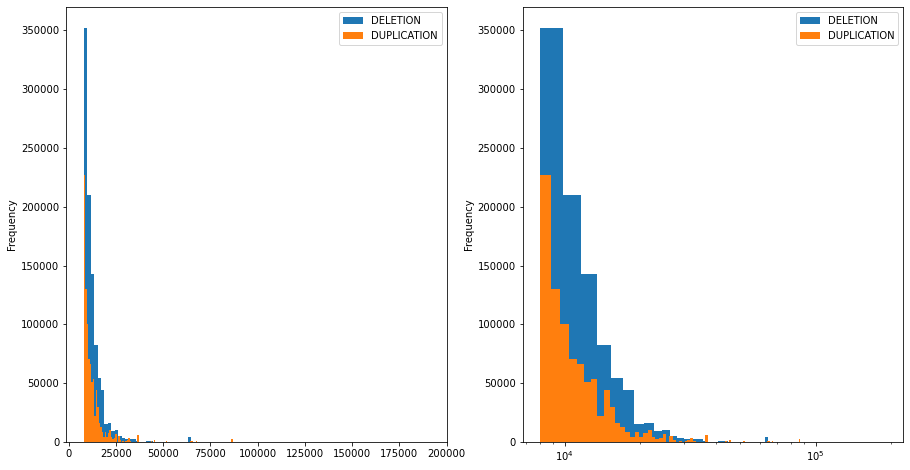

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

df_plot= chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[0]) # alpha for transparency

plt.xscale('log')
#plt.show()

df_plot = chm13.groupby(['TYPE'])['LENGHT']

df_plot.plot(kind='hist',stacked=True, bins=100, legend=True, ax=axs[1]) # alpha for transparency

plt.show()

In [20]:
#subsetting deletions and duplications
deletions = chm13[chm13['TYPE'] =='DELETION']
duplications = chm13[chm13['TYPE'] == 'DUPLICATION']

In [35]:
#change to df when using telomeres and centromeres filtration
final_cnv = duplications.pivot_table(index=["CHR", "START_GENE", "END_GENE"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


final_cnv

SAMPLE   CHR  START_GENE  END_GENE  LP6005441-DNA_A01  LP6005441-DNA_A03  \
0       chr1      111902    112896               12.0               15.0   
1       chr1      602476    626317                NaN                NaN   
2       chr1      608293    614245                NaN                NaN   
3       chr1      850349    853374                NaN                NaN   
4       chr1      850349    853699                NaN                NaN   
...      ...         ...       ...                ...                ...   
10611   chrY    26434554  26437295                5.0                NaN   
10612   chrY    26787942  26801082                4.0                NaN   
10613   chrY    62306324  62368760                NaN                NaN   
10614   chrY    62306354  62368760                NaN                NaN   
10615   chrY    62306357  62366980                NaN                NaN   

SAMPLE  LP6005441-DNA_A04  LP6005441-DNA_A05  LP6005441-DNA_A06  \
0                    11.0               14.0               15.0   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     NaN                NaN                NaN   
...                   ...                ...                ...   
10611                 NaN                4.0                4.0   
10612                 NaN                3.0                3.0   
10613                 NaN                NaN                NaN   
10614                 NaN                NaN                NaN   
10615                 NaN                NaN                NaN   

SAMPLE  LP6005441-DNA_A08  LP6005441-DNA_A09  ...  LP6005677-DNA_D03  \
0                    12.0               11.0  ...               15.0   
1                     NaN                NaN  ...                NaN   
2                     NaN                NaN  ...                NaN   
3                     NaN                NaN  ...                NaN   
4                     NaN                NaN  ...                NaN   
...                   ...                ...  ...                ...   
10611                 3.0                NaN  ...                NaN   
10612                 4.0                NaN  ...                NaN   
10613                 NaN                NaN  ...                NaN   
10614                 NaN                NaN  ...                NaN   
10615                 NaN                NaN  ...                NaN   

SAMPLE  LP6005677-DNA_E01  LP6005677-DNA_F01  LP6005677-DNA_G01  \
0                    13.0               14.0               14.0   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     NaN                NaN                NaN   
...                   ...                ...                ...   
10611                 4.0                NaN                4.0   
10612                 3.0                NaN                4.0   
10613                 NaN                NaN                NaN   
10614                 NaN                NaN                NaN   
10615                 NaN                NaN                NaN   

SAMPLE  LP6007068-DNA_A01  LP6007069-DNA_A01  SS6004471  SS6004477  SS6004478  \
0                    14.0               12.0       15.0       11.0       13.0   
1                     NaN                NaN        NaN        NaN        NaN   
2                     NaN                NaN        NaN        NaN        NaN   
3                     NaN                3.0        NaN        NaN        NaN   
4                     NaN                3.0        NaN        NaN        NaN   
...                   ...                ...        ...        ...        ...   
10611                 4.0                NaN 

In [36]:
from scipy import stats
#final_cnv = final_cnv.iloc[new]
final = final_cnv.iloc[:,3:284]
counts = final
counts = counts.fillna(2)

#counts = counts[counts.columns.intersection(counts_a.columns)]

#counts = counts.drop(columns=['LP6005592-DNA_G03',
#                     'LP6005443-DNA_E10',
#                     'LP6005442-DNA_E04'])

counts = counts.T
counts = counts.sort_index()
counts

0      1      2      3      4      5      6      7      \
SAMPLE                                                                      
LP6005441-DNA_A01   12.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A03   15.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A04   11.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A05   14.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A06   15.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
LP6007069-DNA_A01   12.0    2.0    2.0    3.0    3.0    3.0    3.0    3.0   
SS6004471           15.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
SS6004477           11.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
SS6004478           13.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   
SS6004480           16.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0   

                   8      9      ...  10606  10607  10608  10609  10610  \
SAMPLE                           ...                                      
LP6005441-DNA_A01    3.0    3.0  ...    4.0    4.0    3.5    5.0    5.0   
LP6005441-DNA_A03    2.0    2.0  ...    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A04    3.0    3.0  ...    2.0    2.0    2.0    2.0    2.0   
LP6005441-DNA_A05    2.0    2.0  ...    3.0    3.0    3.0    4.0    4.0   
LP6005441-DNA_A06    3.0    3.0  ...    3.0    3.0    3.0    4.0    4.0   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
LP6007069-DNA_A01    2.0    2.0  ...    2.0    2.0    2.0    2.0    2.0   
SS6004471            3.0    3.0  ...    3.0    3.0    3.0    3.0    3.0   
SS6004477            3.0    3.0  ...    3.5    4.0    3.5    4.0    4.0   
SS6004478            3.0    3.0  ...    2.0    2.0    2.0    2.0    2.0   
SS6004480            3.0    3.0  ...    3.0    3.0    3.0    4.0    4.0   

                   10611  10612  10613  10614  10615  
SAMPLE                                                
LP6005441-DNA_A01    5.0    4.0    2.0    2.0    2.0  
LP6005441-DNA_A03    2.0    2.0    2.0    2.0    2.0  
LP6005441-DNA_A04    2.0    2.0    2.0    2.0    2.0  
LP6005441-DNA_A05    4.0    3.0    2.0    2.0    2.0  
LP6005441-DNA_A06    4.0    3.0    2.0    2.0    2.0  
...                  ...    ...    ...    ...    ...  
LP6007069-DNA_A01    2.0    2.0    2.0    2.0    2.0  
SS6004471            3.0    3.0    2.0    2.0    2.0  
SS6004477            4.0    3.0    2.0    2.0    2.0  
SS6004478            2.0    2.0    2.0    2.0    2.0  
SS6004480            4.0    4.0    2.0    2.0    2.0  

[269 rows x 10616 columns]

In [37]:
features = ids_hg19.set_index('SAMPLE').merge(counts, left_index=True, right_index=True)
features = features.loc[:,['REGION',]]
features = features.sort_index()
features 

REGION
SAMPLE                        
LP6005441-DNA_A01  WestEurasia
LP6005441-DNA_A03      Oceania
LP6005441-DNA_A04      America
LP6005441-DNA_A05  WestEurasia
LP6005441-DNA_A06  WestEurasia
...                        ...
LP6007069-DNA_A01  WestEurasia
SS6004471               Africa
SS6004477              Oceania
SS6004478              Oceania
SS6004480               Africa

[269 rows x 1 columns]

In [38]:
#PCA
pca = PCA(n_components=10)
pca_results = pca.fit_transform(counts)

df_pca= pd.DataFrame(pca_results,
                          columns=['component_1','component_2', 'component_3', 'component_4',
                                  'component_5',
                                  'component_6',
                                  'component_7',
                                  'component_8',
                                  'component_9',
                                   'component_10'
                                  ],
                          index=features.index)




df_pca = features.merge(df_pca, left_index=True, right_index=True)
df_pca

REGION  component_1  component_2  component_3  \
SAMPLE                                                                  
LP6005441-DNA_A01  WestEurasia    -4.382670    11.958085    -0.885920   
LP6005441-DNA_A03      Oceania    37.175185   -37.849861     1.936519   
LP6005441-DNA_A04      America     1.821882     0.444657    28.970865   
LP6005441-DNA_A05  WestEurasia    71.676898   -10.018428    38.354872   
LP6005441-DNA_A06  WestEurasia  -142.375200    33.637289   -19.687217   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01  WestEurasia   -46.899665   -72.827647    77.501423   
SS6004471               Africa    38.817708  -117.537469   -16.822664   
SS6004477              Oceania  -105.489378   -88.076398     3.041862   
SS6004478              Oceania  -124.664442  -113.679376    42.156322   
SS6004480               Africa   -85.014119  -161.283328    63.480592   

                   component_4  component_5  component_6  component_7  \
SAMPLE                                                                  
LP6005441-DNA_A01     8.739782    -6.172818    -5.052578     1.062138   
LP6005441-DNA_A03   -14.492155     3.993621     6.481295     2.095594   
LP6005441-DNA_A04   -12.687251     3.885396    14.396784     0.609873   
LP6005441-DNA_A05     1.939131    -3.934883    -4.613114    -8.061670   
LP6005441-DNA_A06     7.146312     2.249871   -22.623886    -1.723376   
...                        ...          ...          ...          ...   
LP6007069-DNA_A01   -22.840856    -9.173429     6.143341     3.471486   
SS6004471             9.013644     1.518032   -13.380121    10.584512   
SS6004477            13.406546    -6.241130    -2.344227    -6.987261   
SS6004478           -20.727573     3.229853    10.195889   -16.125691   
SS6004480            33.202111    -7.704495    19.872022   -13.176695   

                   component_8  component_9  component_10  
SAMPLE                                                     
LP6005441-DNA_A01     4.923727     7.770014     -1.240710  
LP6005441-DNA_A03     7.513248    -0.207893      1.634888  
LP6005441-DNA_A04    26.375541    -6.661401      5.574549  
LP6005441-DNA_A05    18.481424     1.801605     -0.555478  
LP6005441-DNA_A06     5.881653    -4.857530     -3.224862  
...                        ...          ...           ...  
LP6007069-DNA_A01    -2.395433     4.080870     10.402668  
SS6004471            -9.167074    20.432116     14.058347  
SS6004477            -8.732028     6.726228     14.297737  
SS6004478             5.085979    -0.169634     13.830518  
SS6004480            -0.097775    -3.556895      0.714325  

[269 rows x 11 columns]

In [39]:
pca.explained_variance_ratio_

array([0.55320984, 0.24521561, 0.06312681, 0.0246949 , 0.01533121,
       0.01331687, 0.00882447, 0.00670094, 0.00611403, 0.00325041])

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa        -85.014119  -161.283328   

Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa     

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa        -85.014119  -161.283328   

/branchinecta/jbazanwilliamson/cnv_analysis/cnv_sgdp/scripts/pca_plot.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  tight_layout=True


             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa        -85.014119  -161.283328   

             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa        -85.014119  -161.283328   

Count of groups by factor: 7
             component_1  component_2  component_3  component_4  component_5  \
REGION                                                                         
WestEurasia    -4.382670    11.958085    -0.885920     8.739782    -6.172818   
Oceania        37.175185   -37.849861     1.936519   -14.492155     3.993621   
America         1.821882     0.444657    28.970865   -12.687251     3.885396   
WestEurasia    71.676898   -10.018428    38.354872     1.939131    -3.934883   
WestEurasia  -142.375200    33.637289   -19.687217     7.146312     2.249871   
...                  ...          ...          ...          ...          ...   
WestEurasia   -46.899665   -72.827647    77.501423   -22.840856    -9.173429   
Africa         38.817708  -117.537469   -16.822664     9.013644     1.518032   
Oceania      -105.489378   -88.076398     3.041862    13.406546    -6.241130   
Oceania      -124.664442  -113.679376    42.156322   -20.727573     3.229853   
Africa     

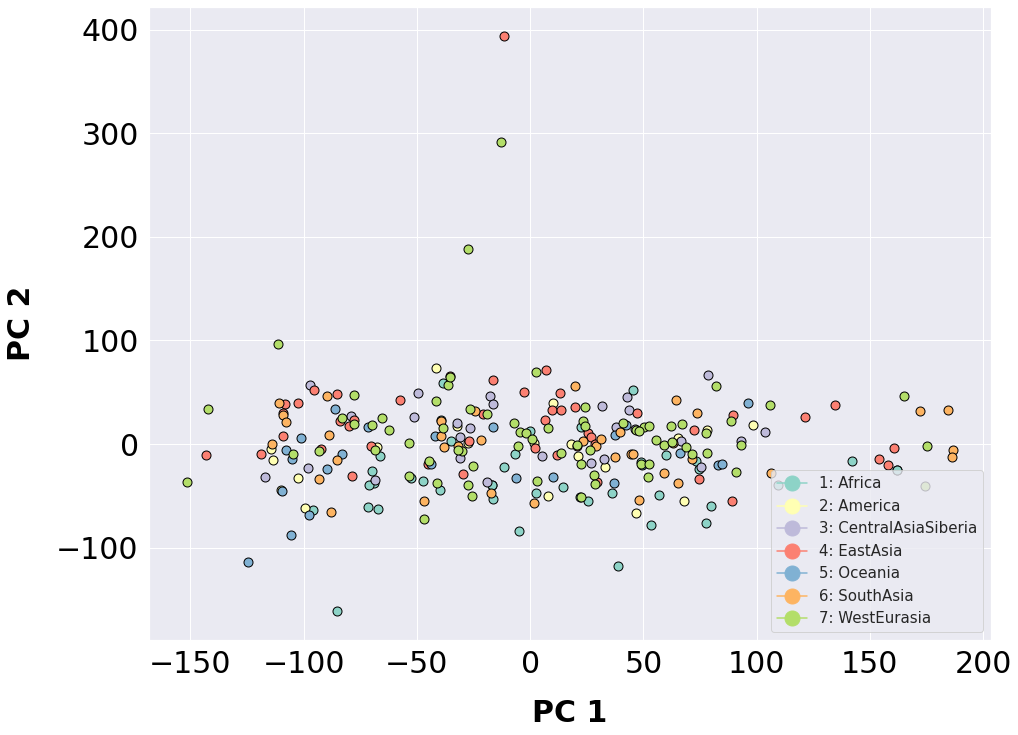

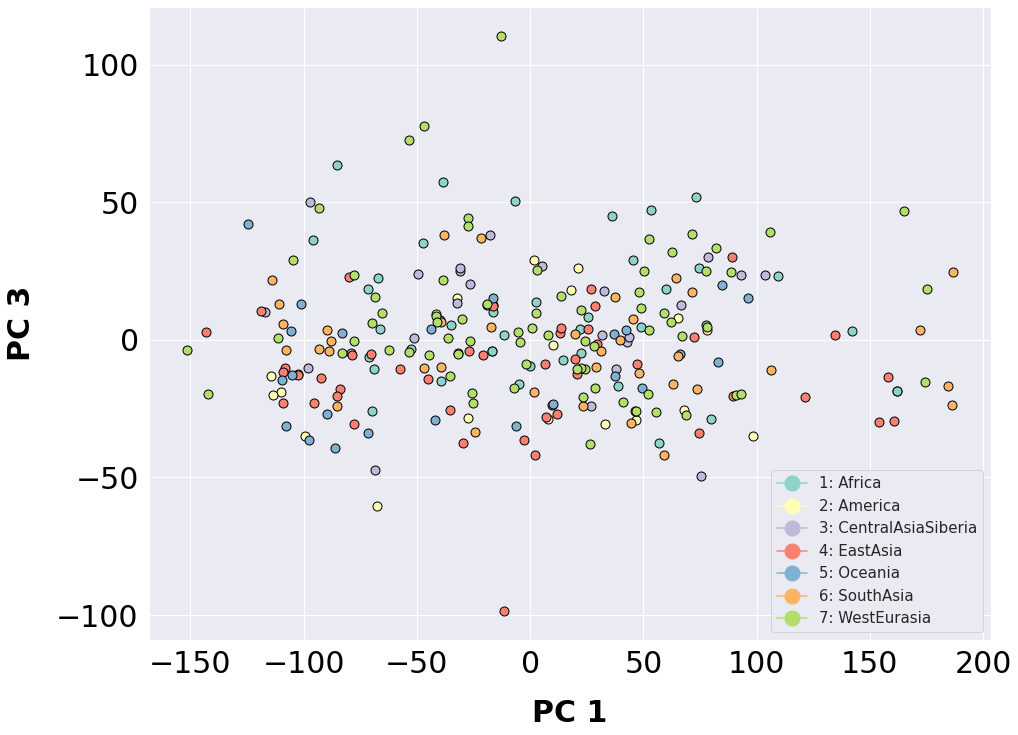

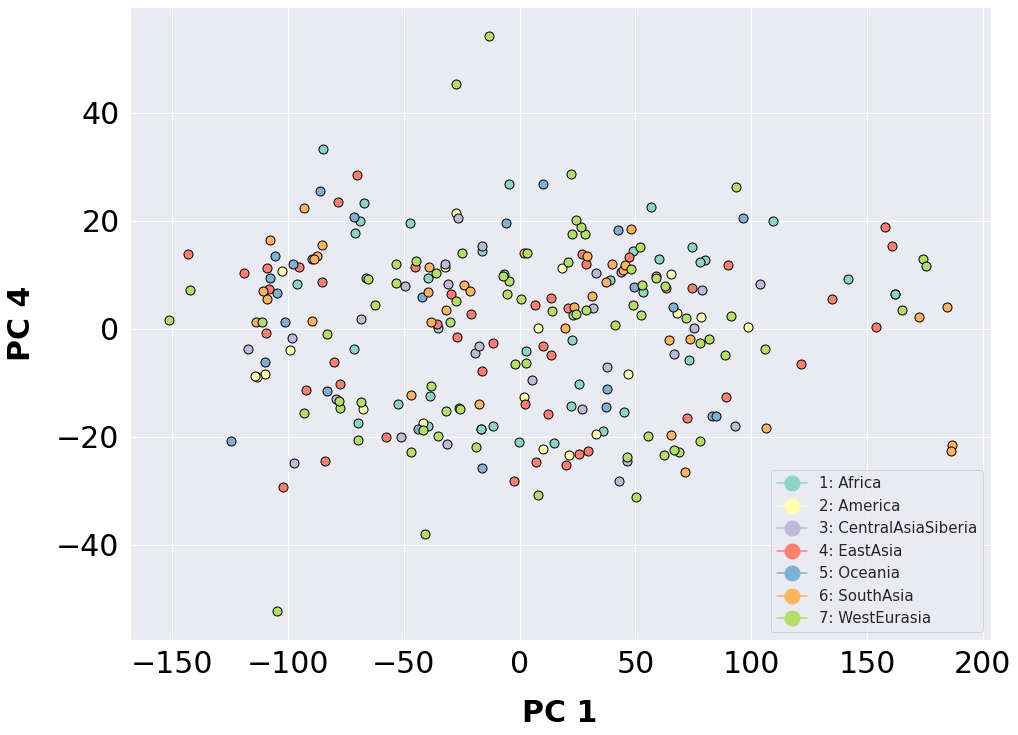

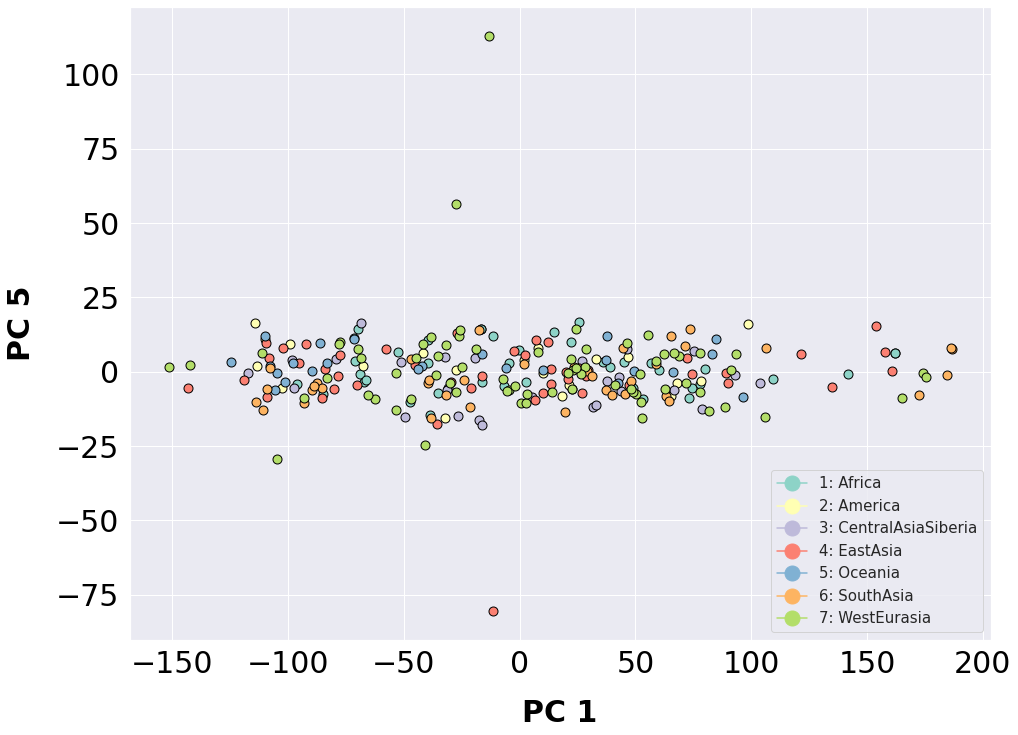

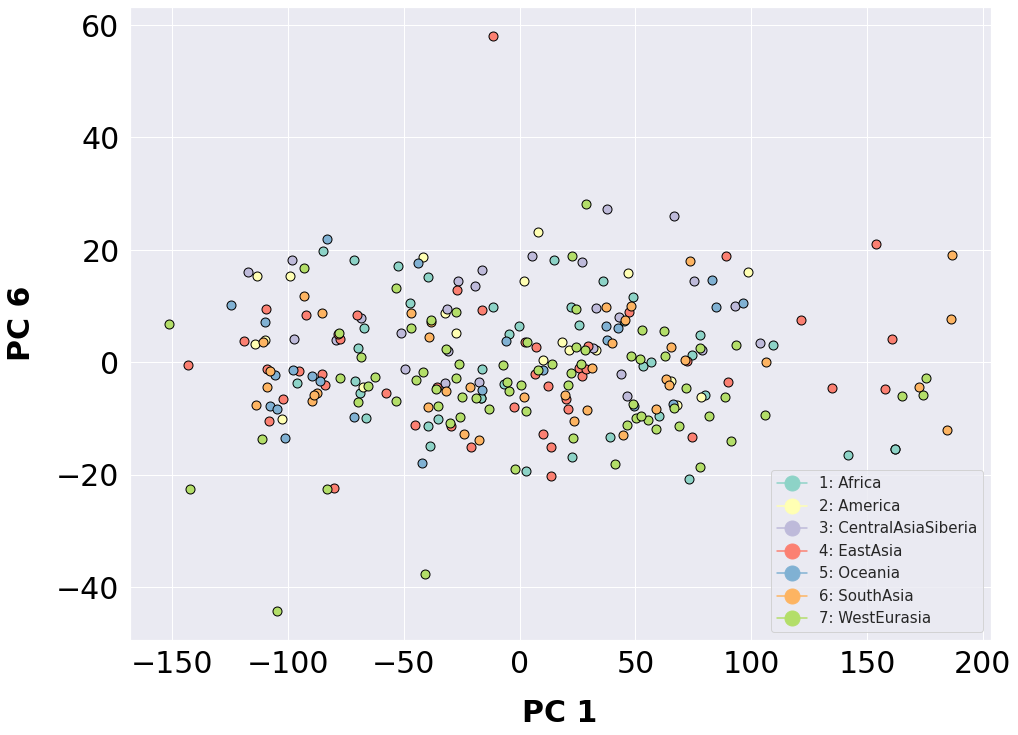

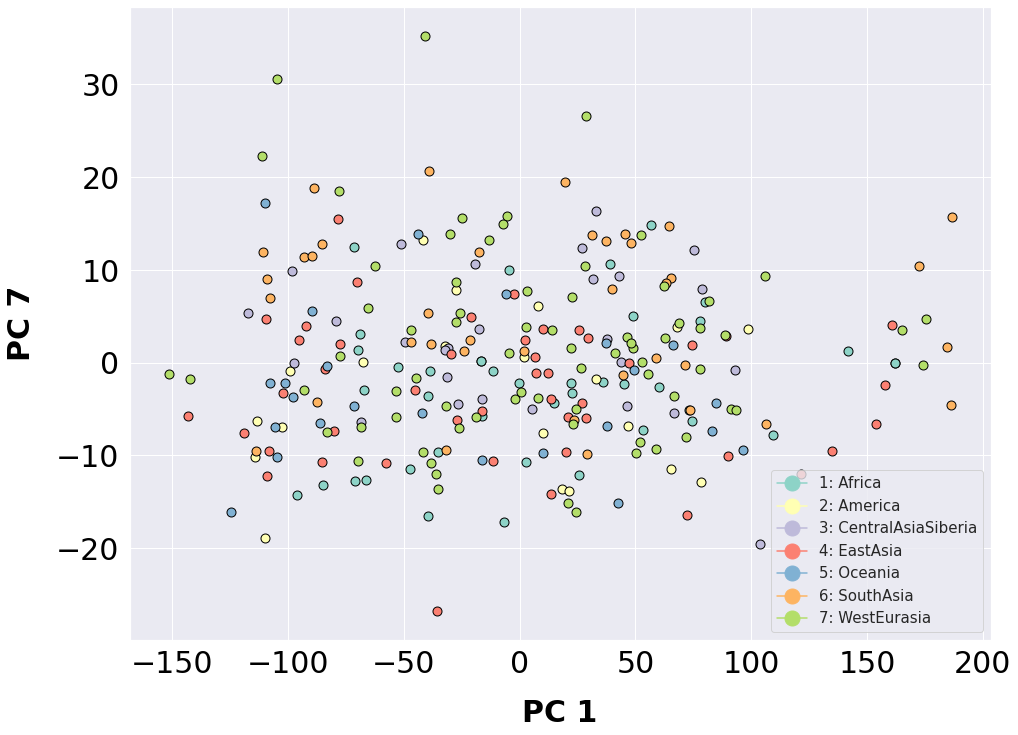

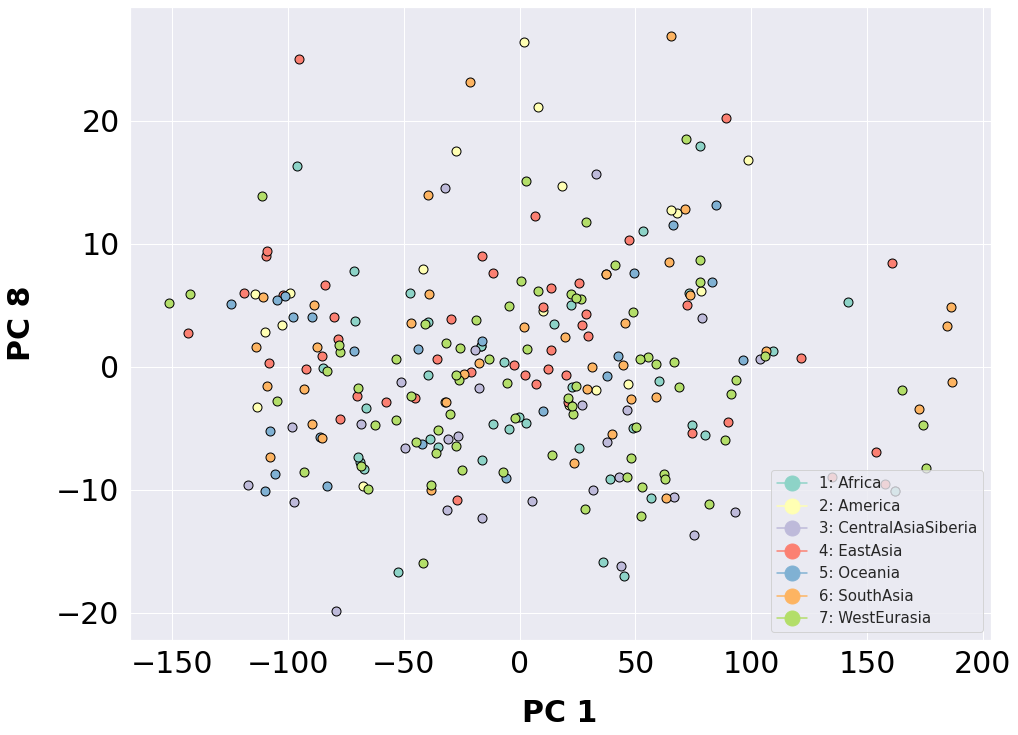

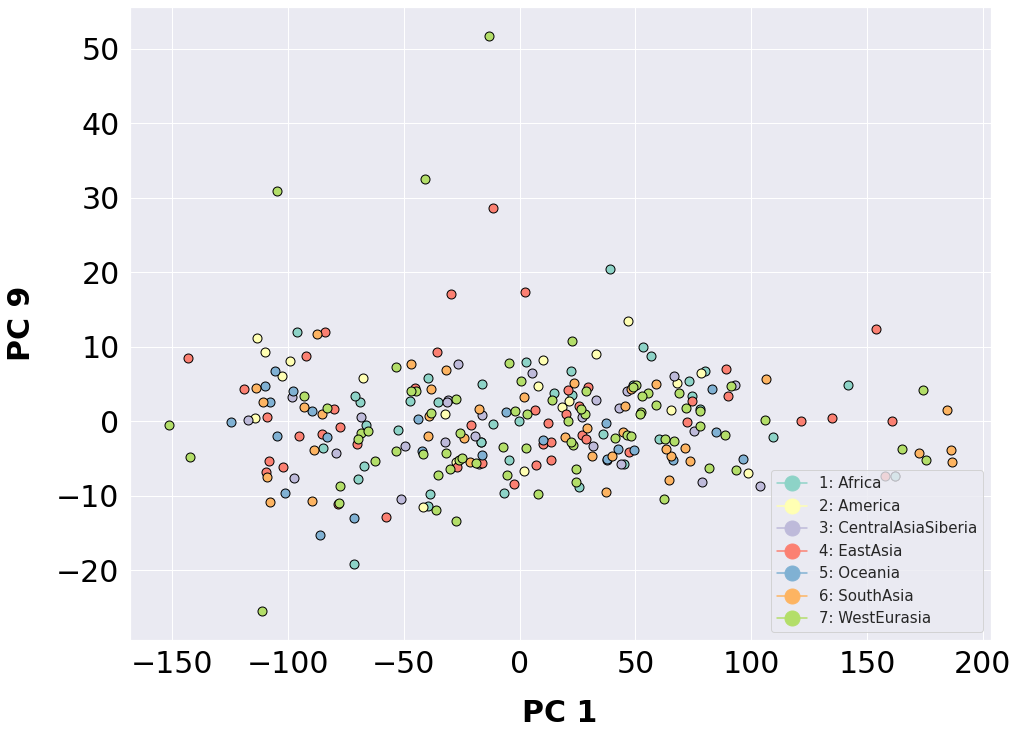

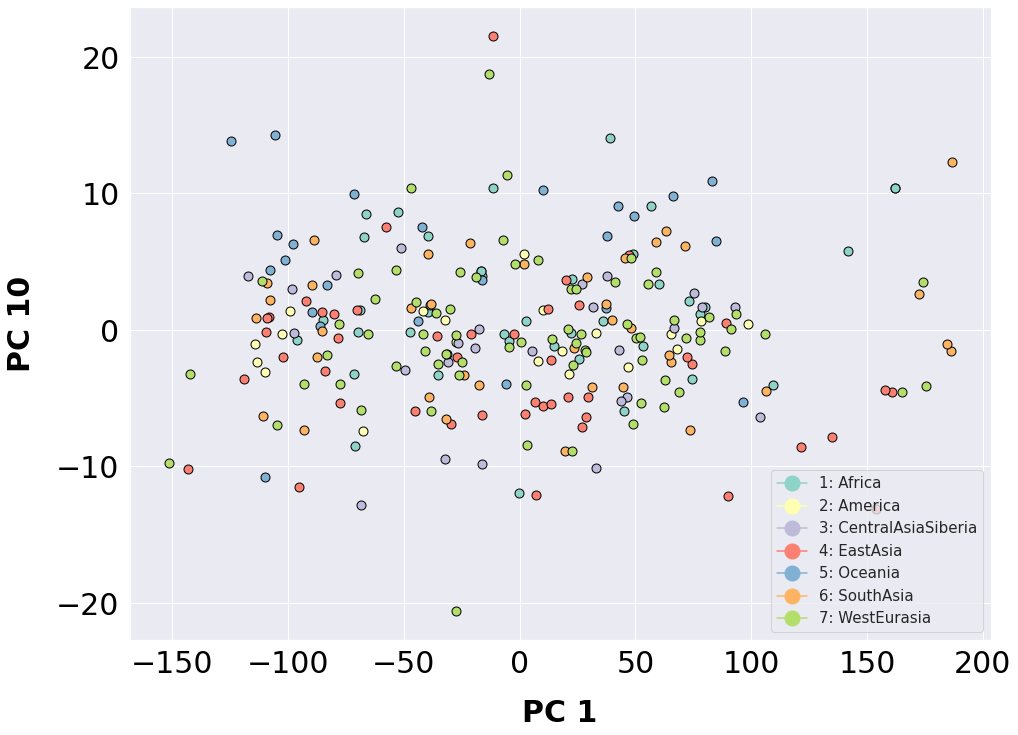

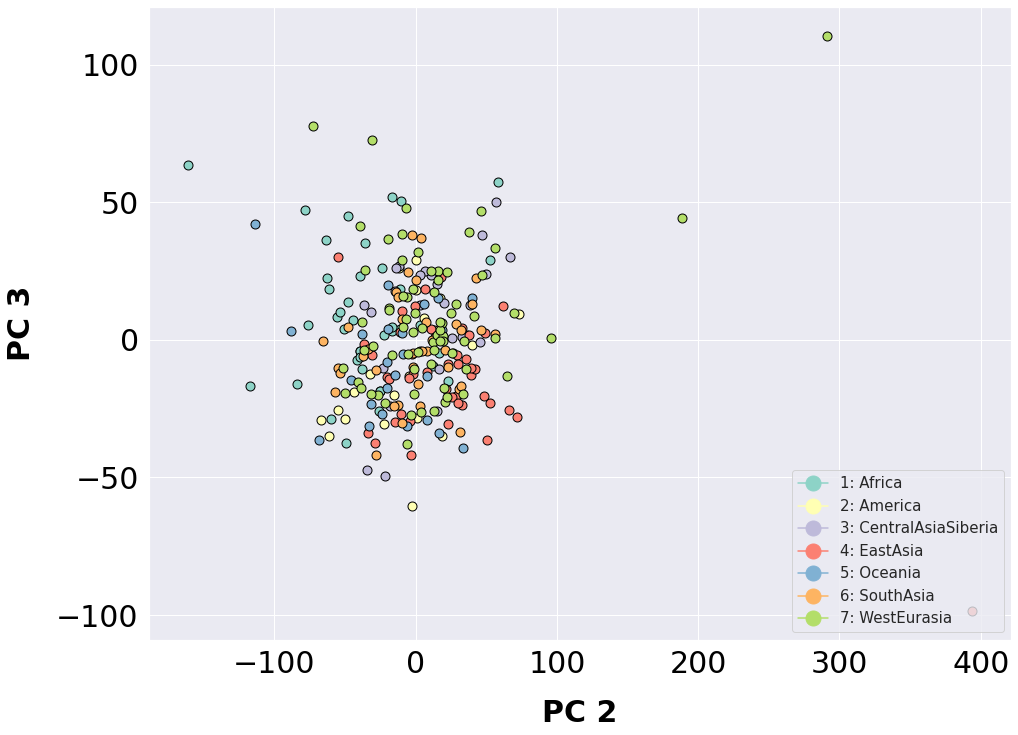

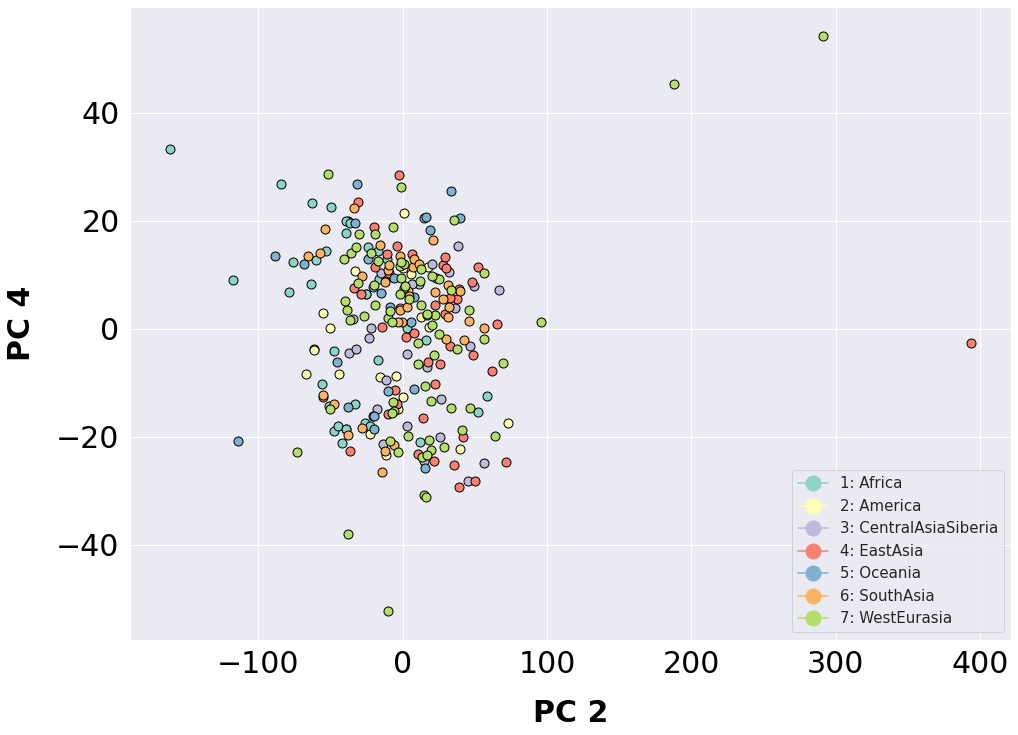

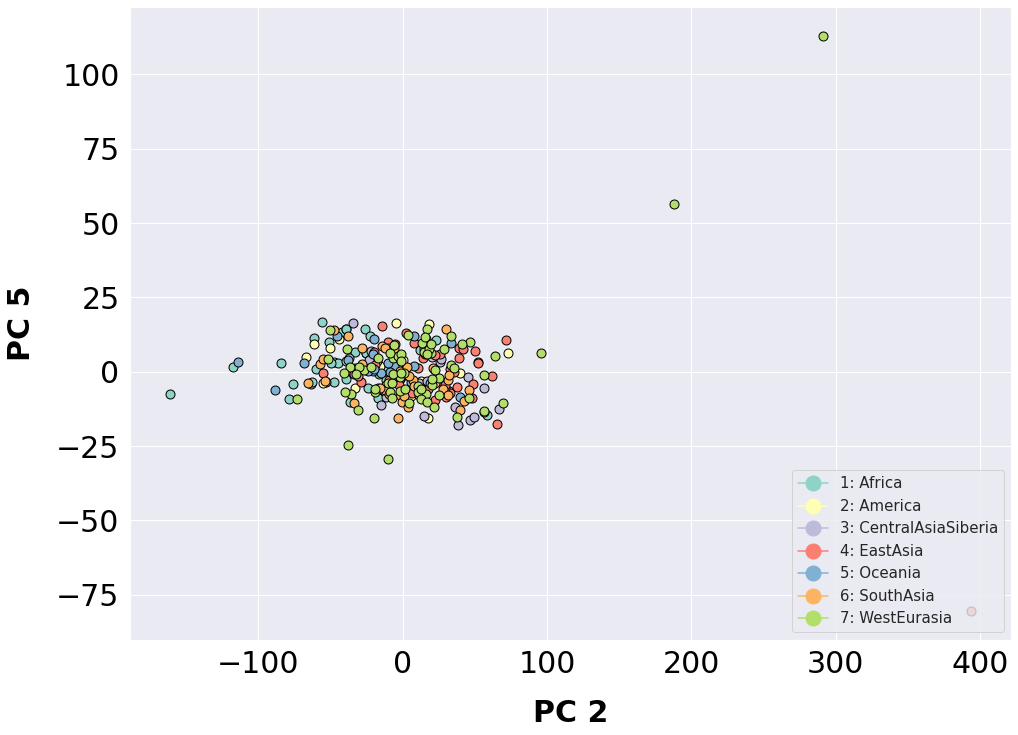

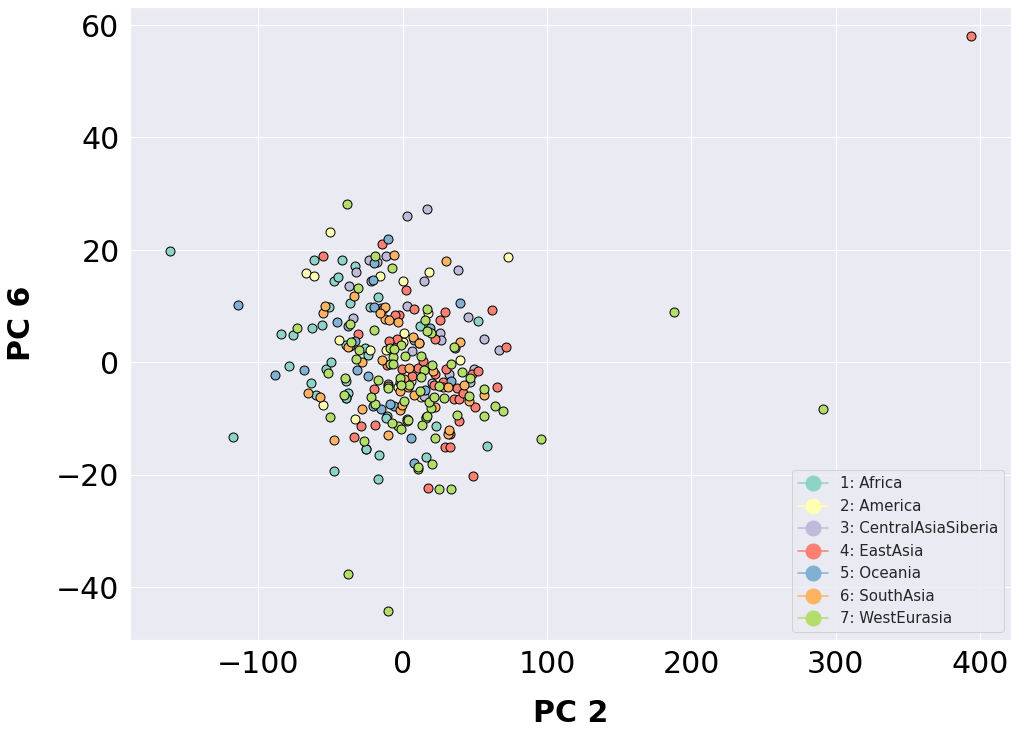

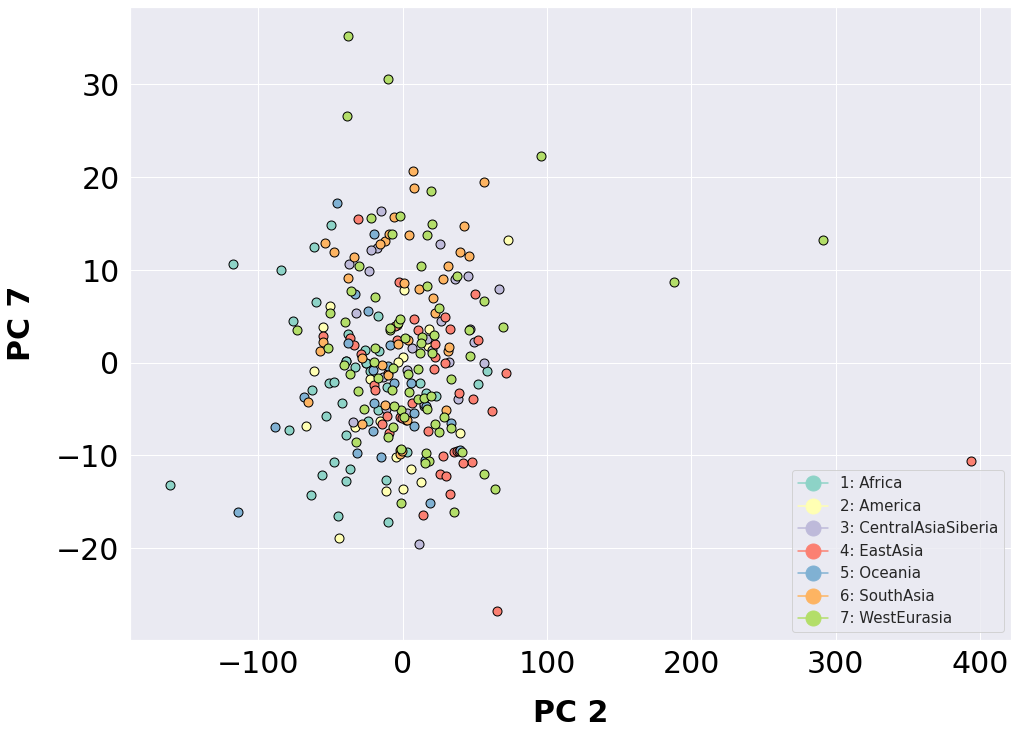

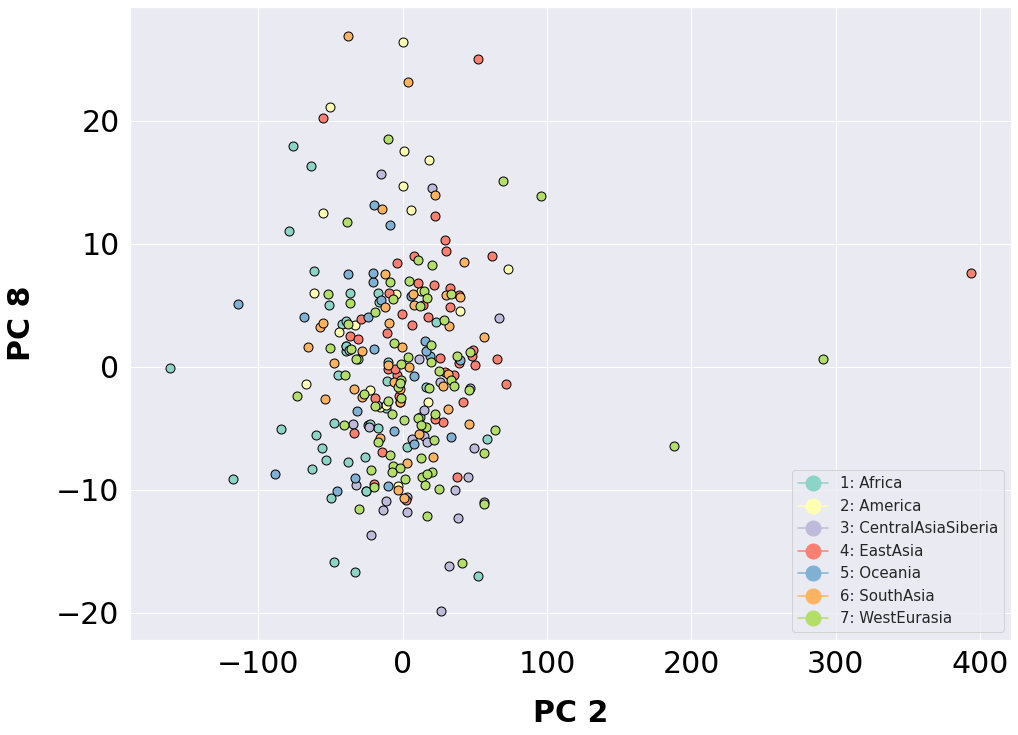

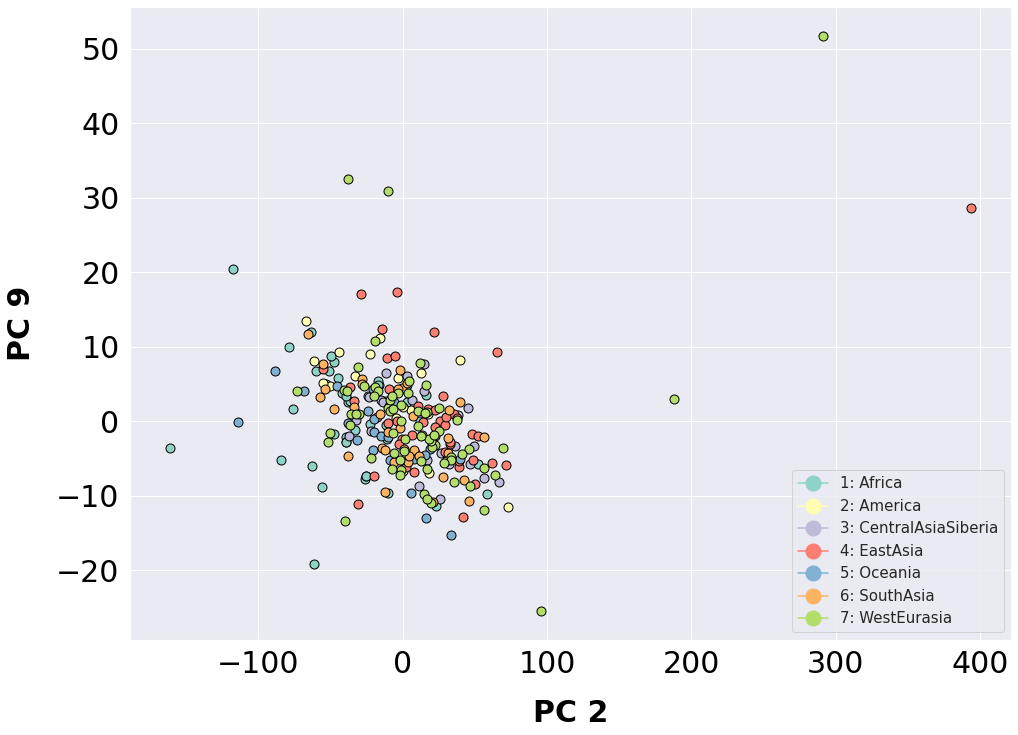

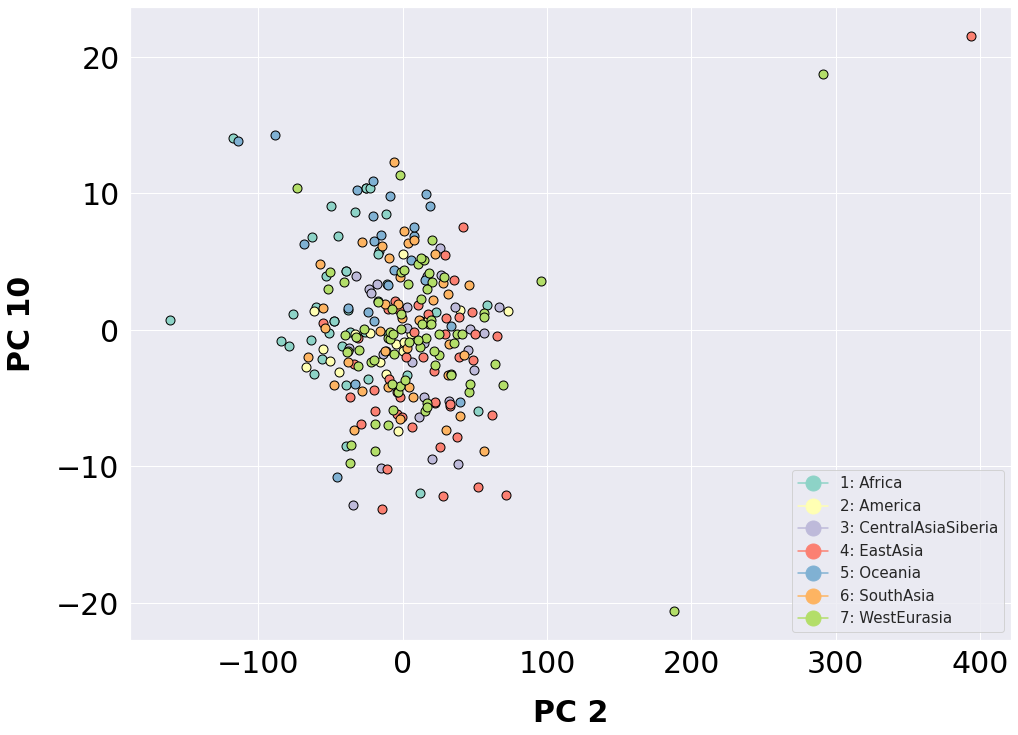

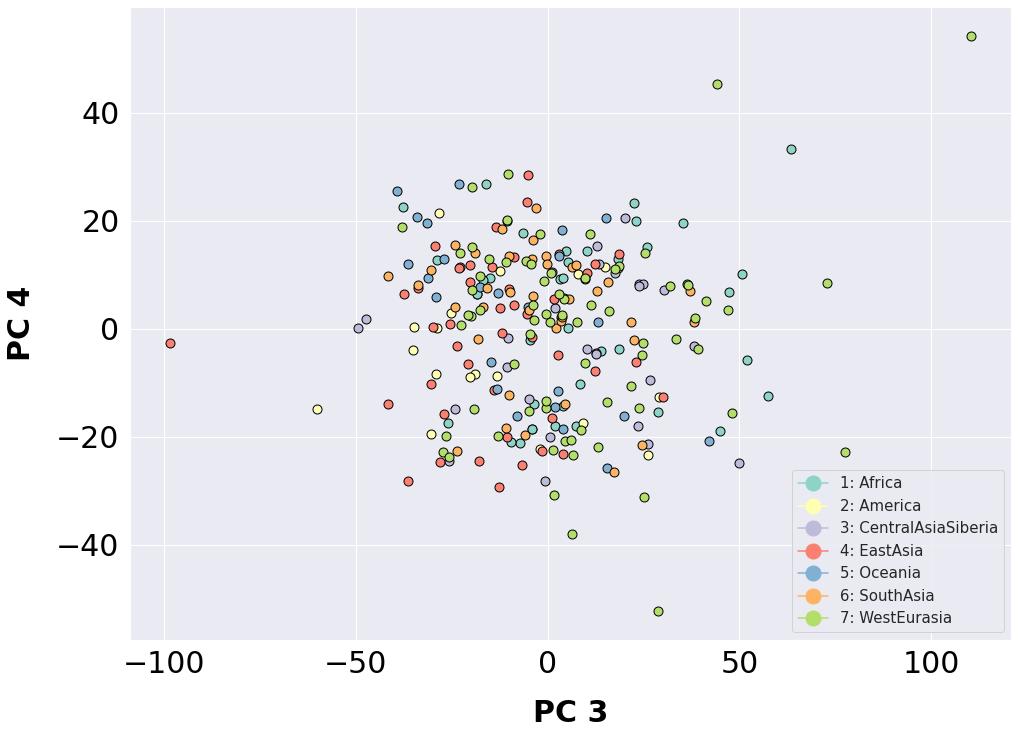

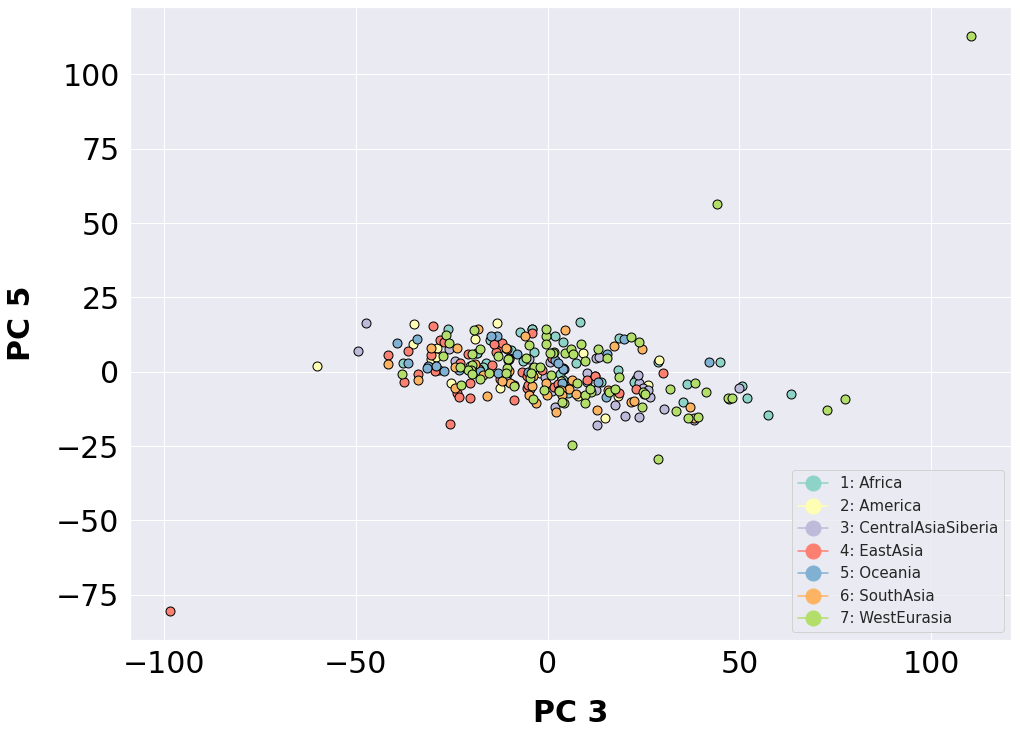

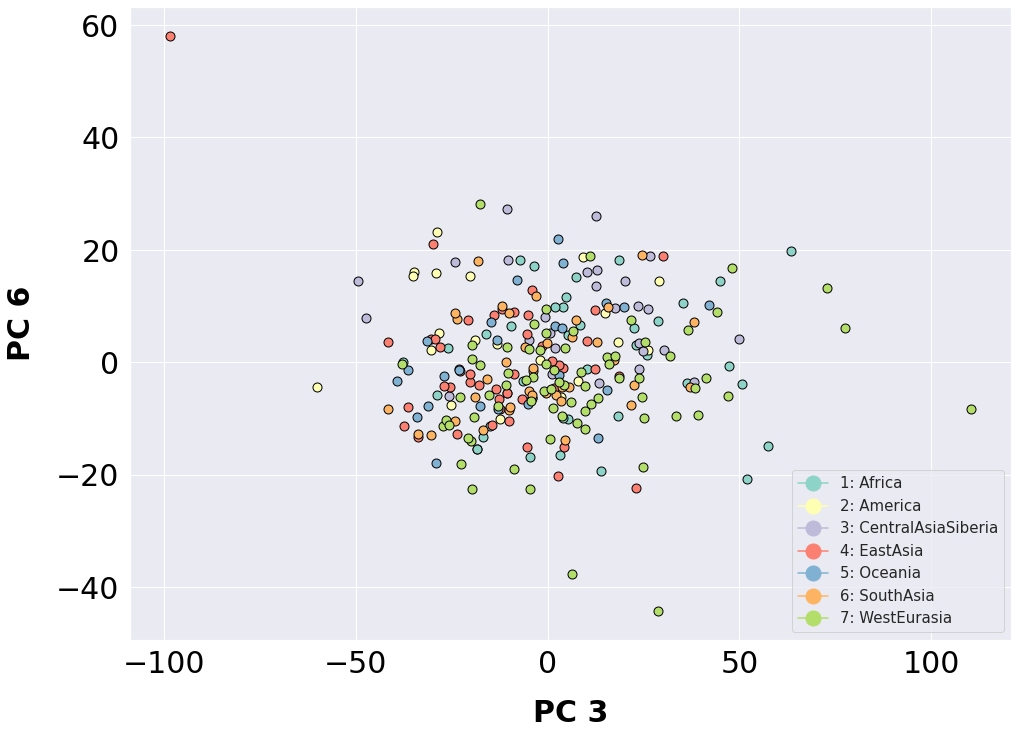

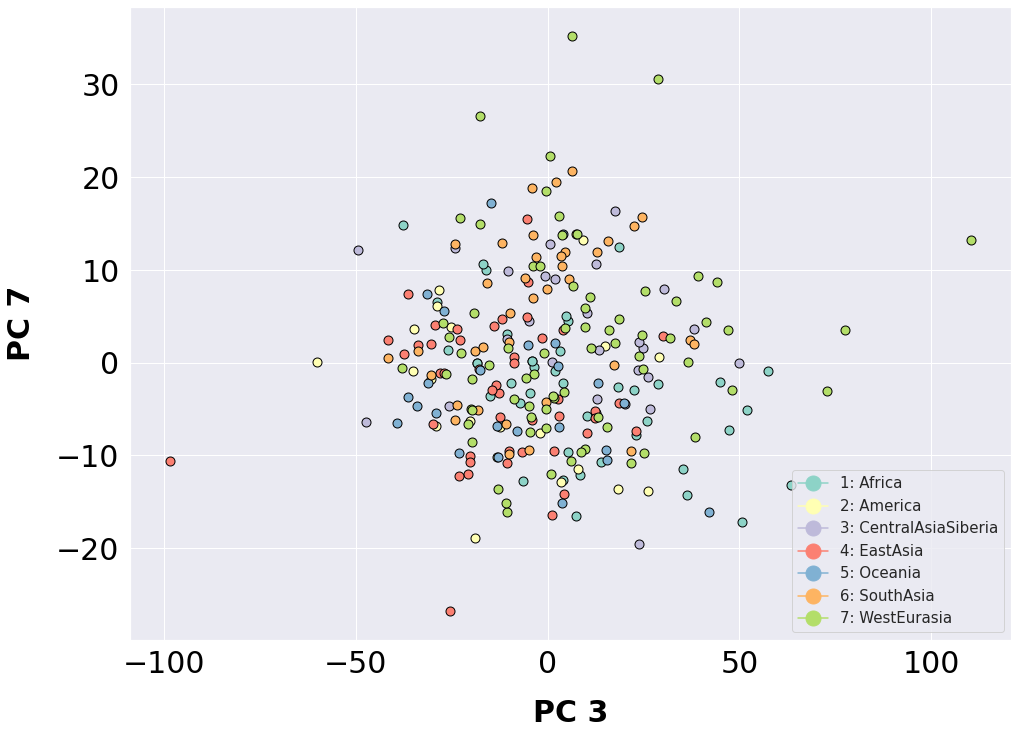

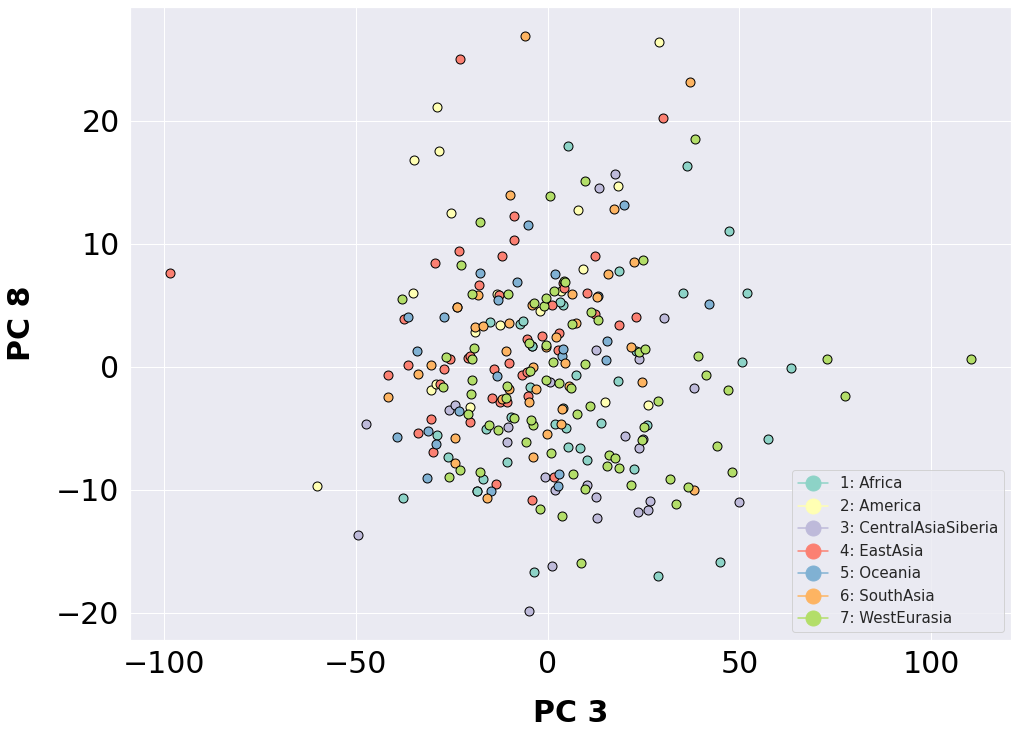

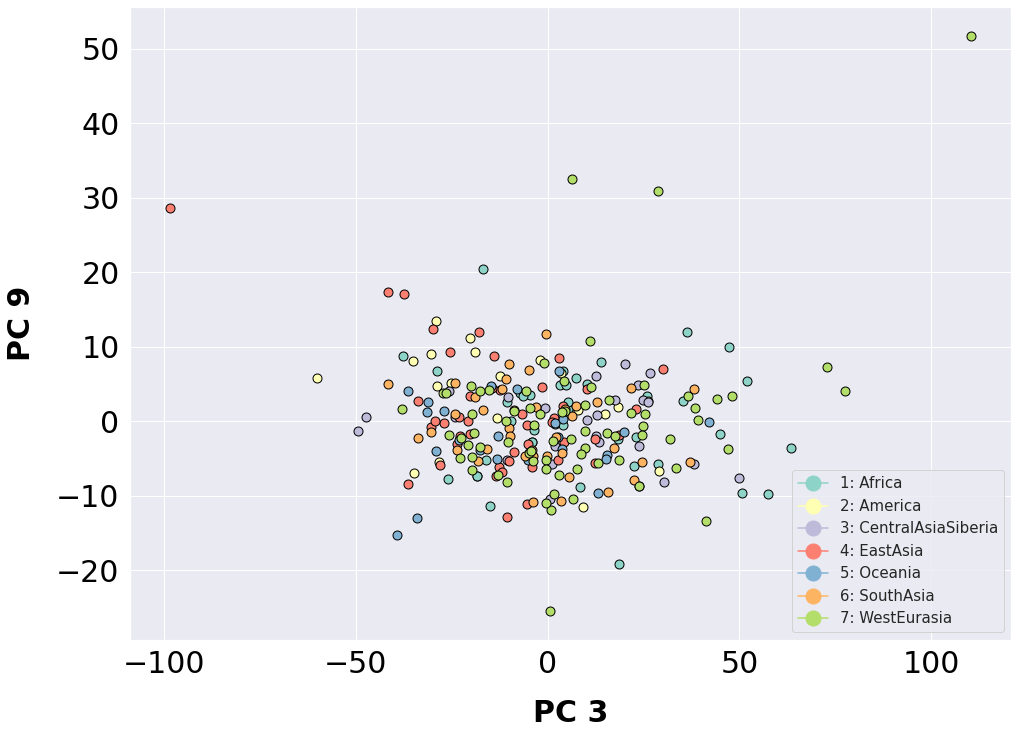

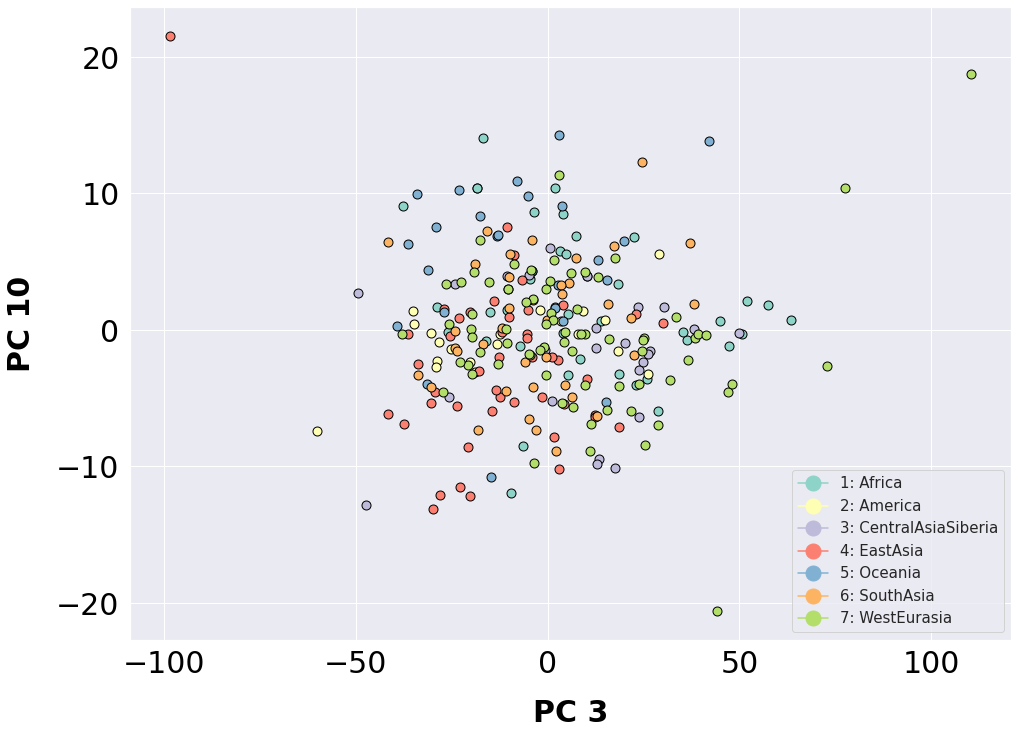

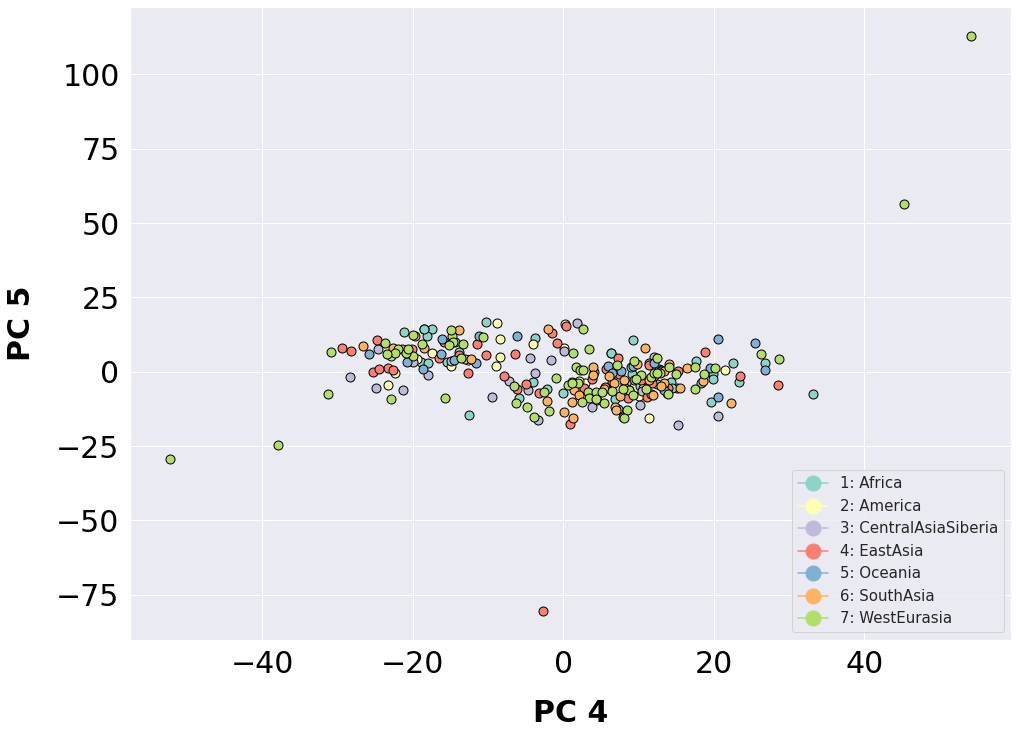

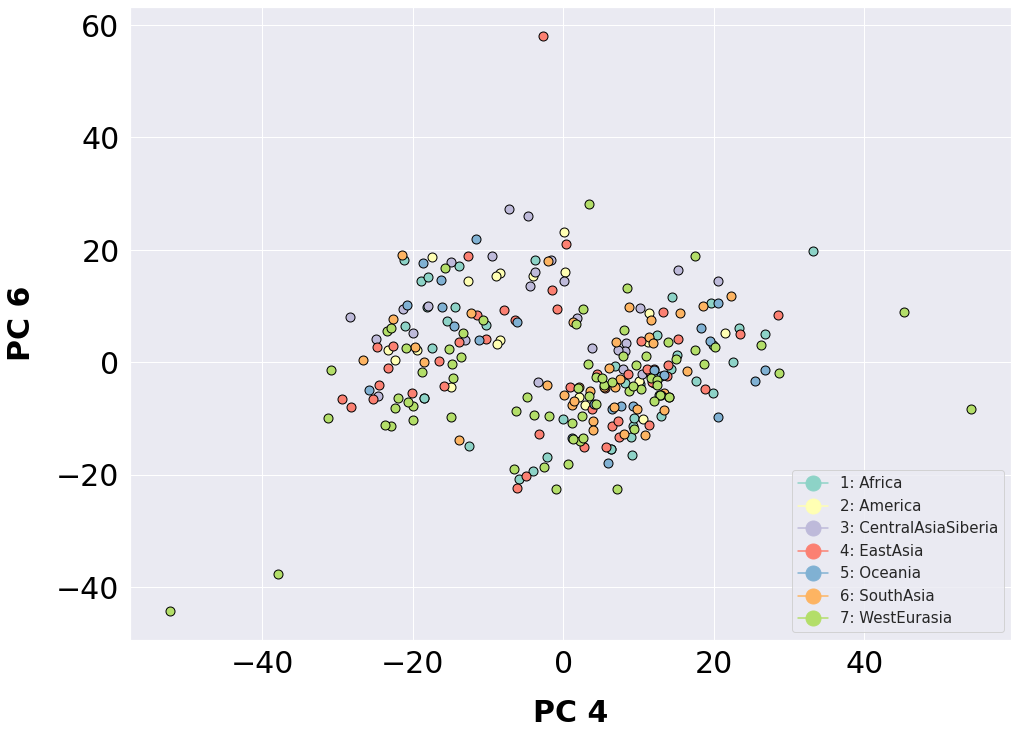

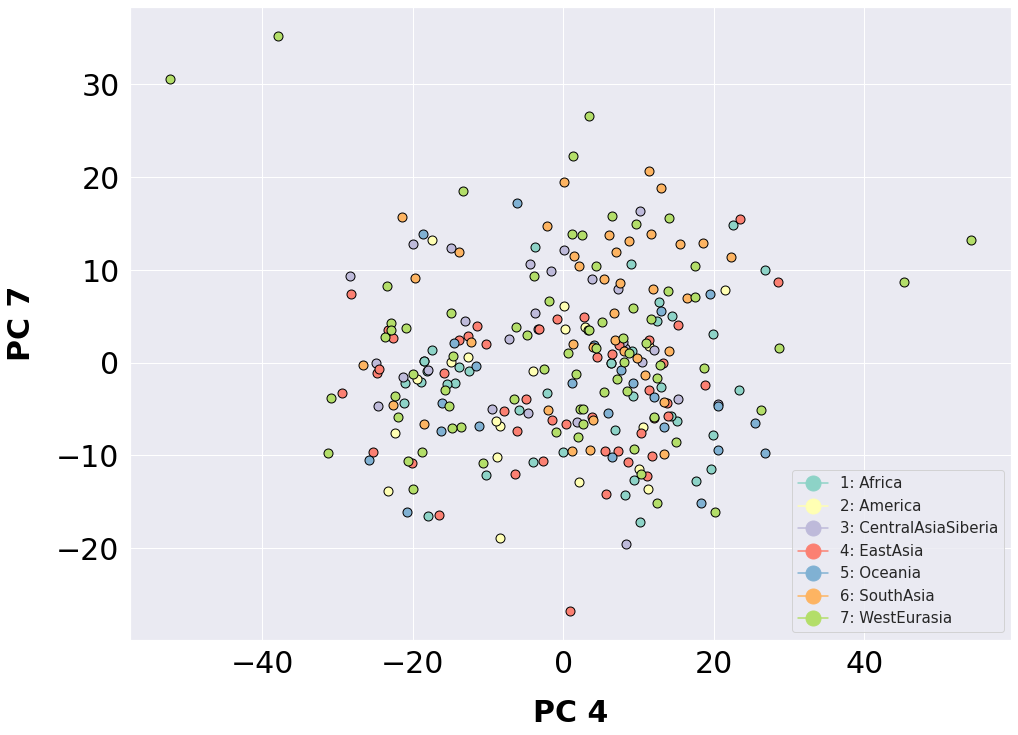

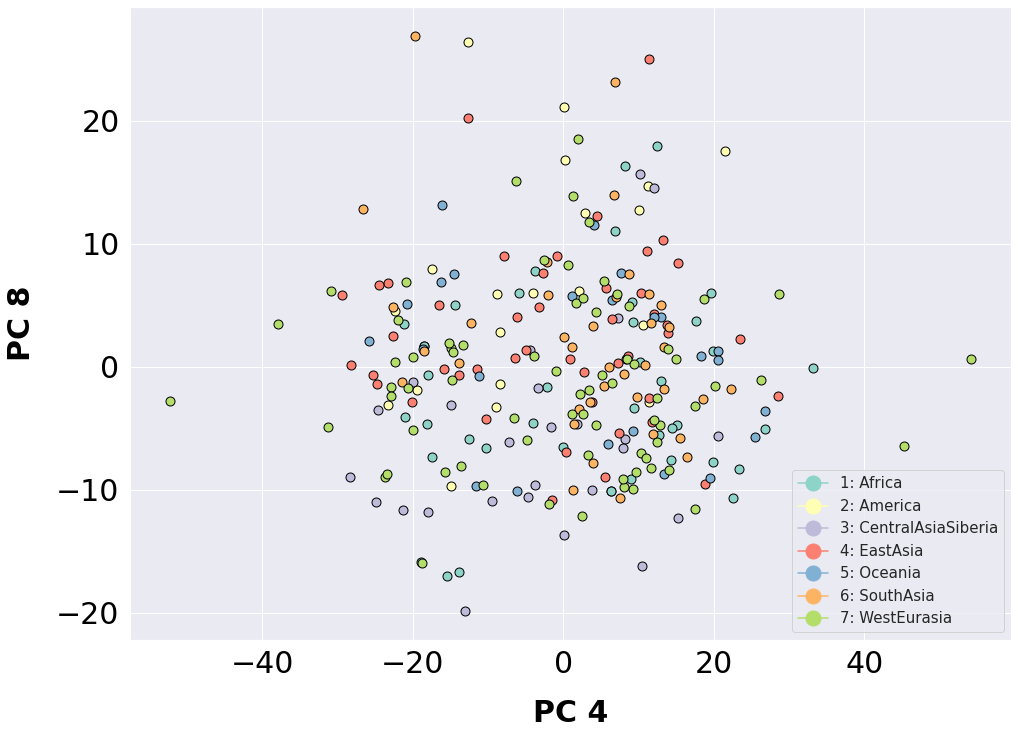

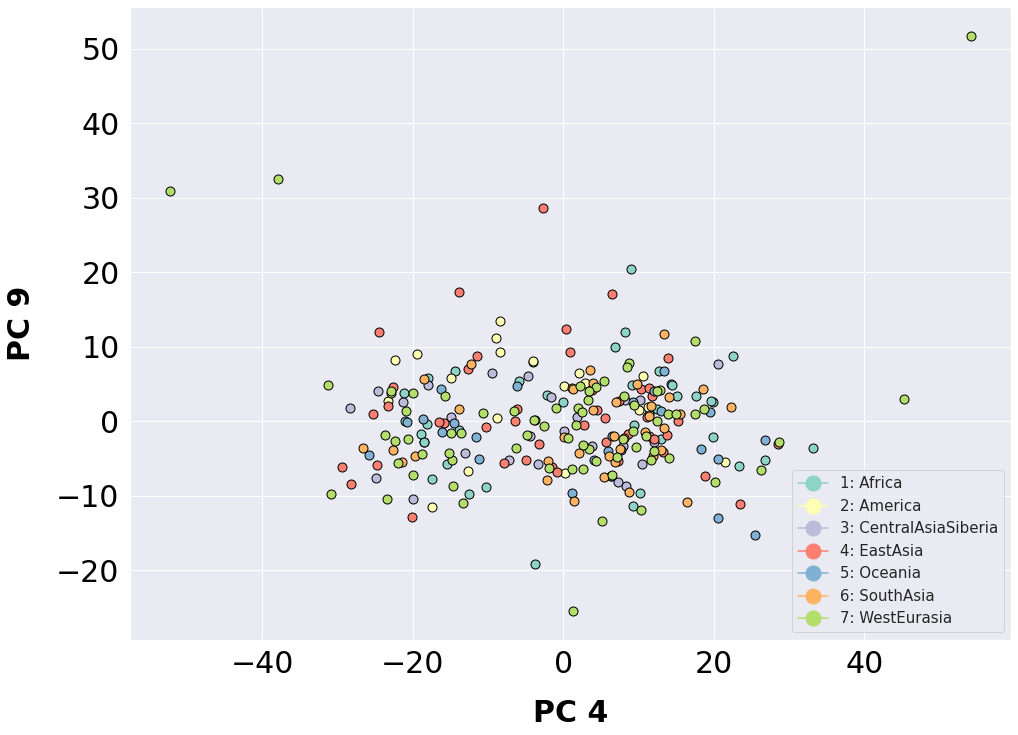

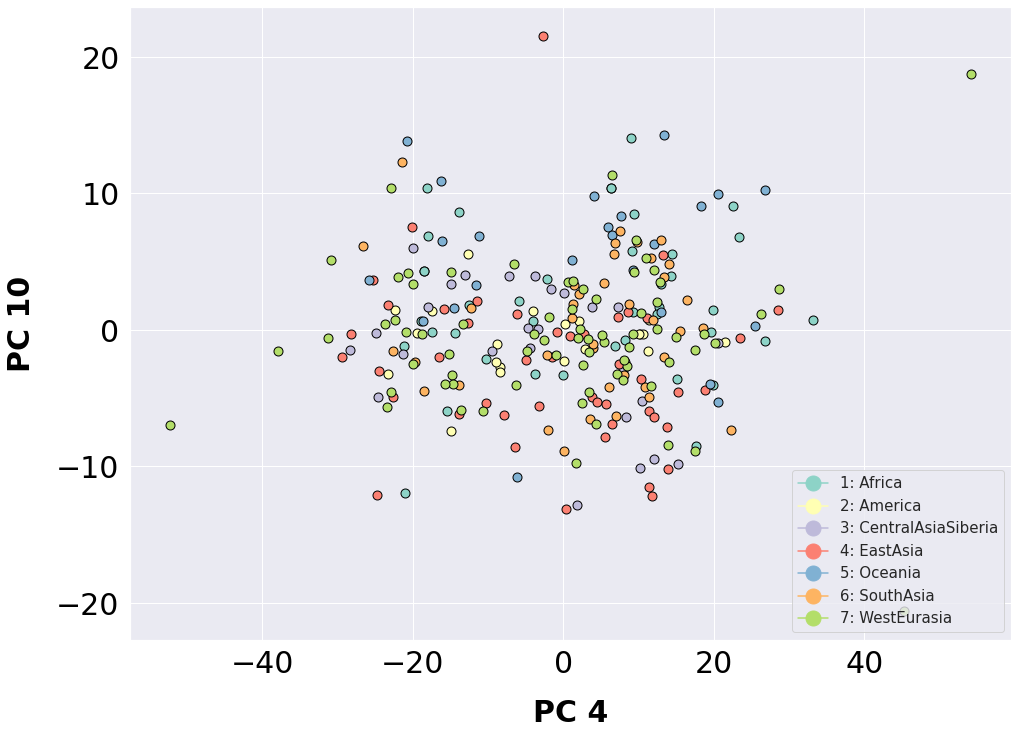

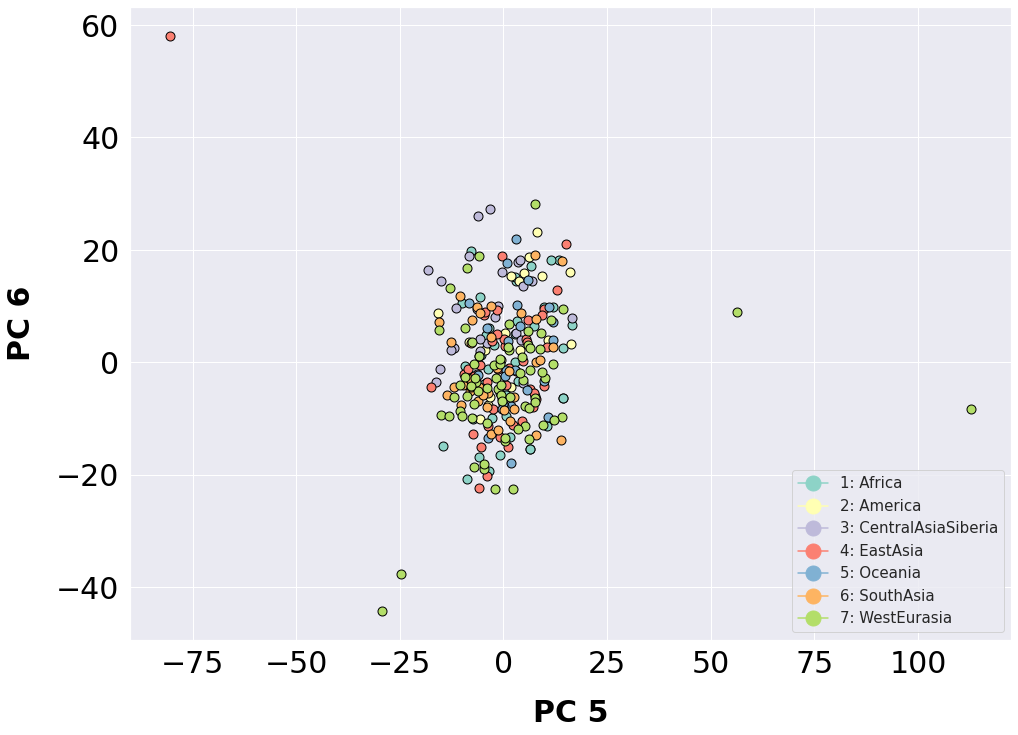

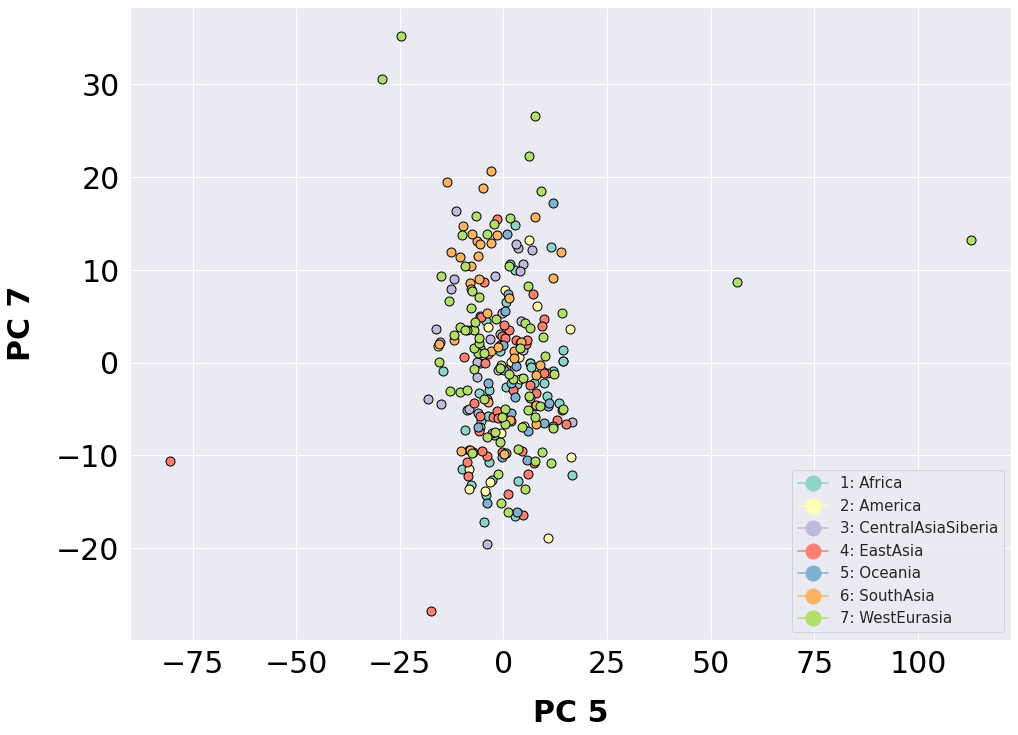

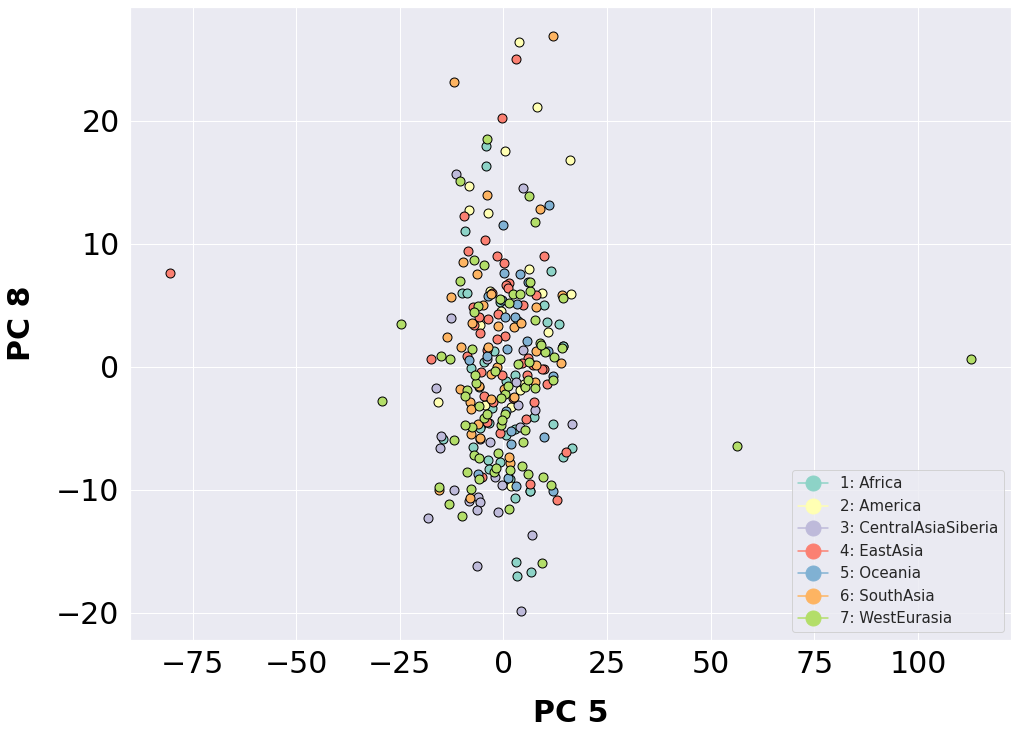

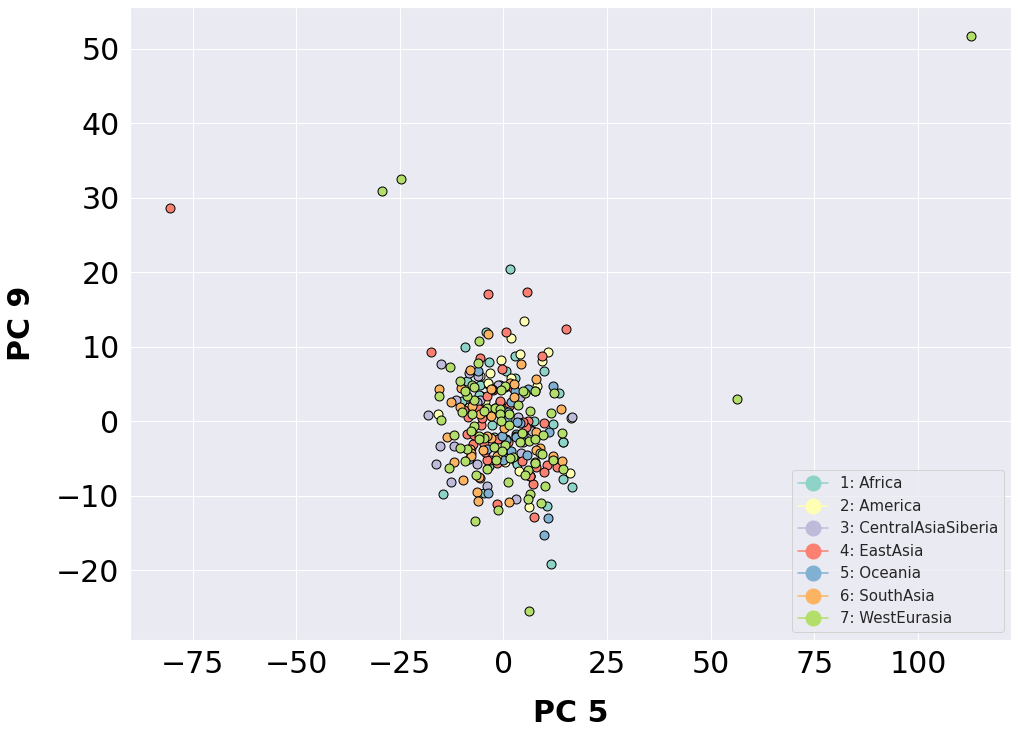

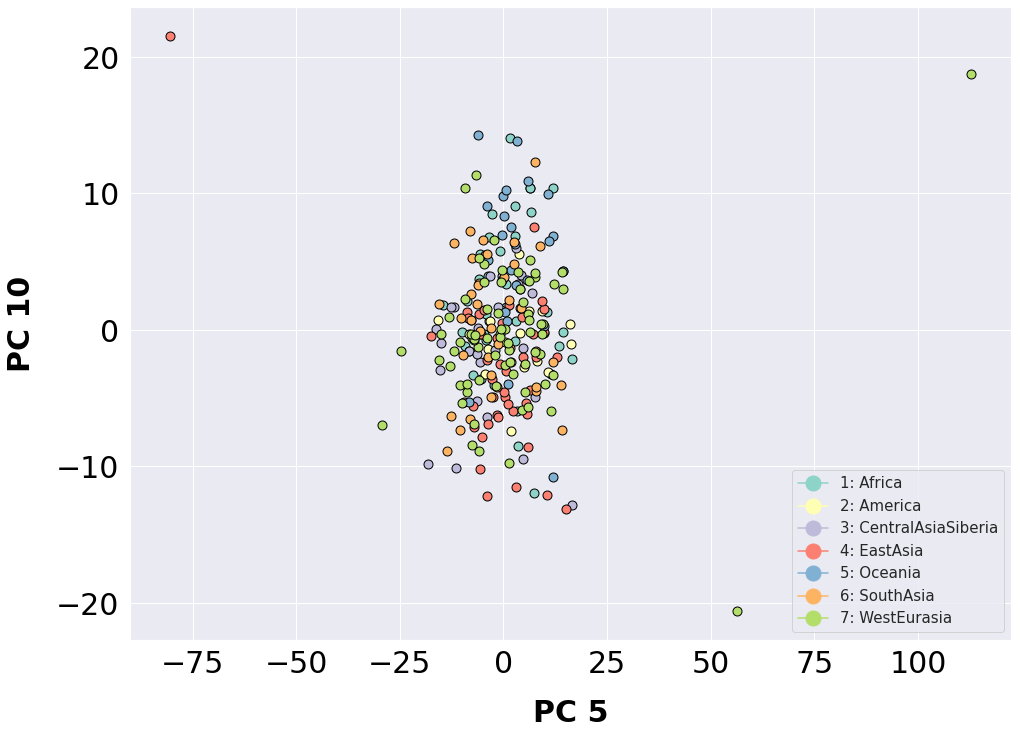

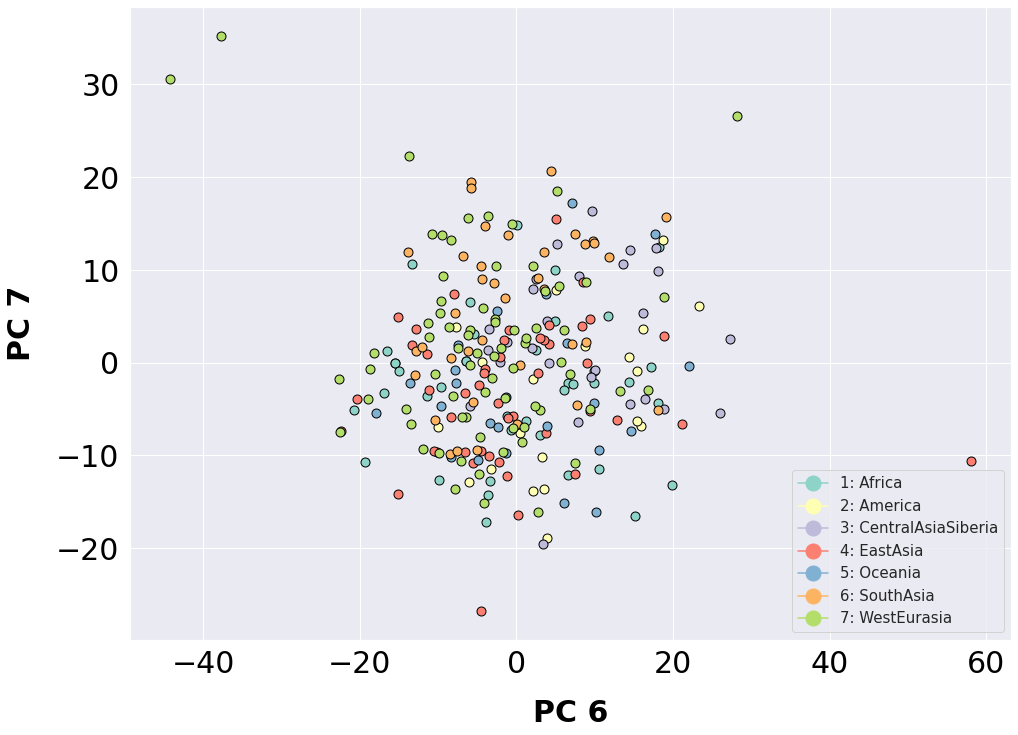

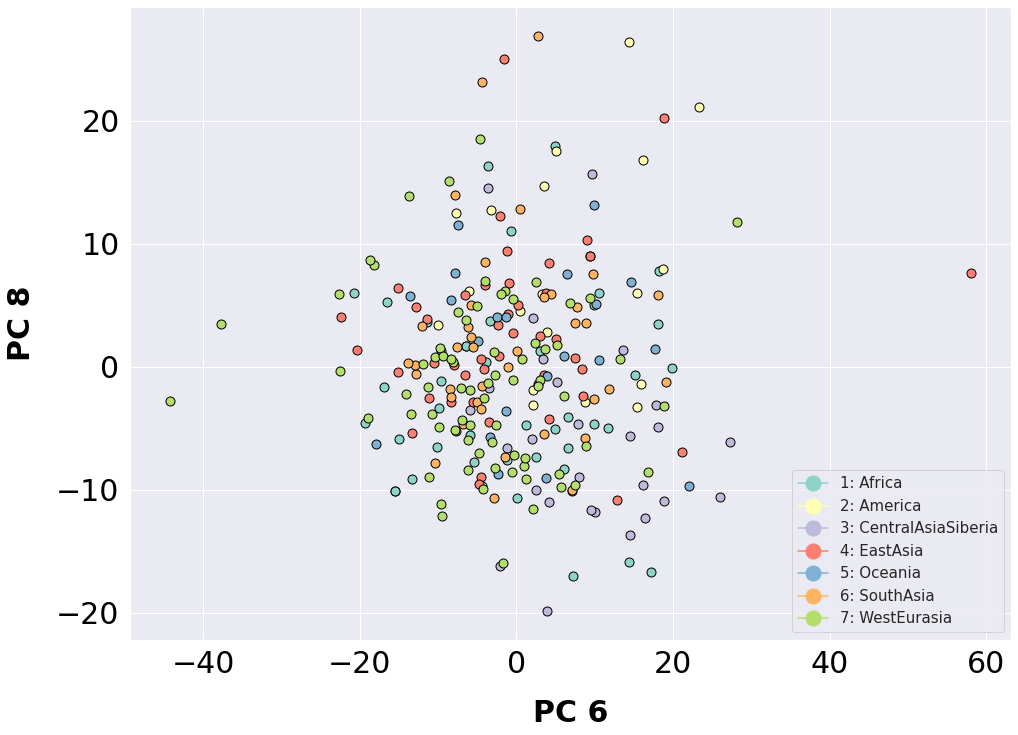

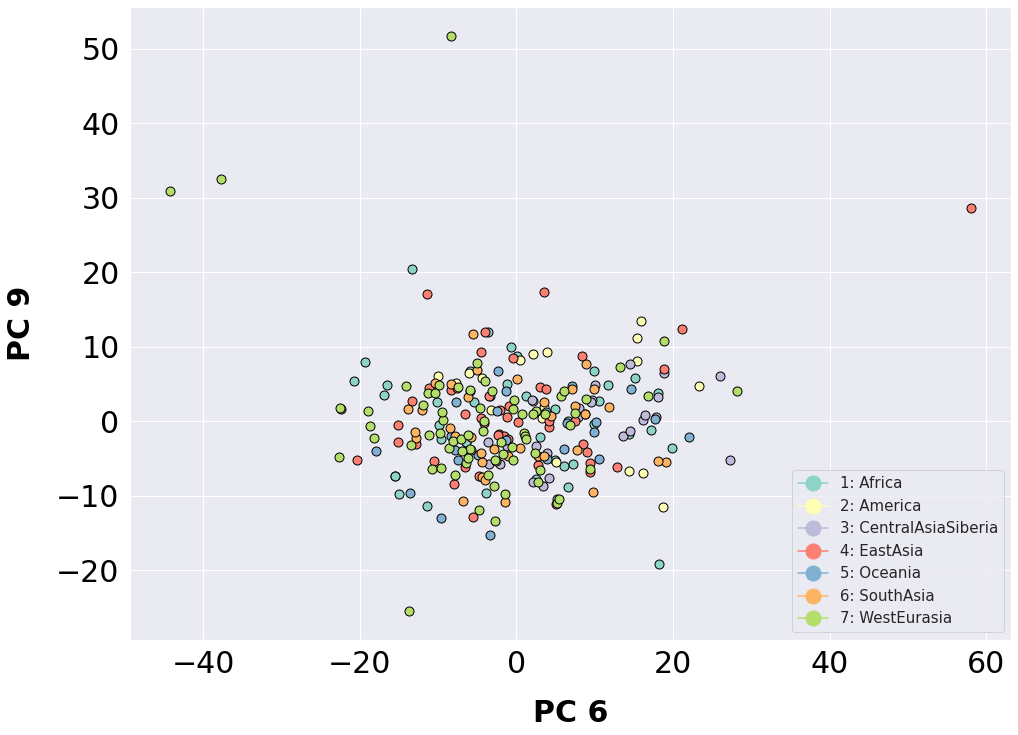

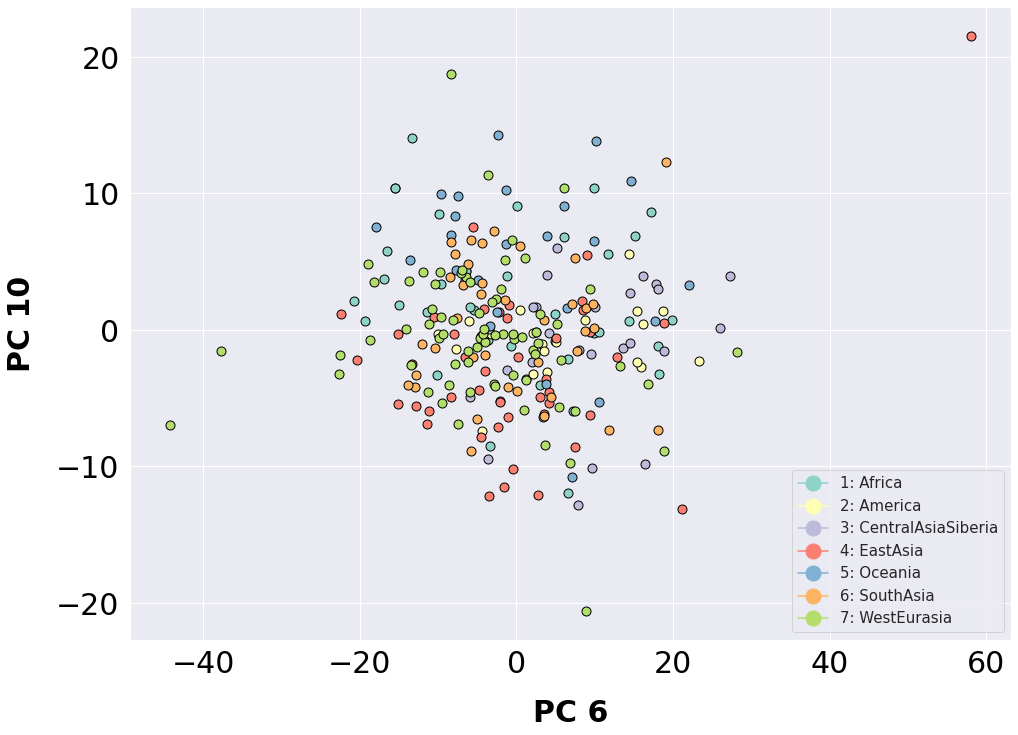

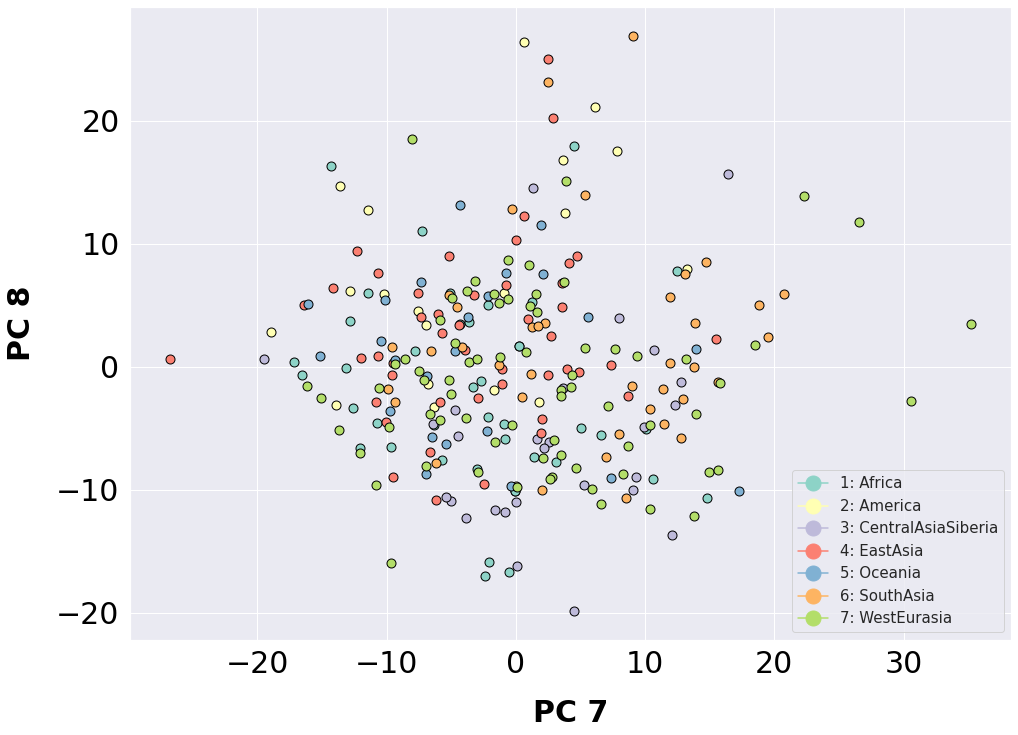

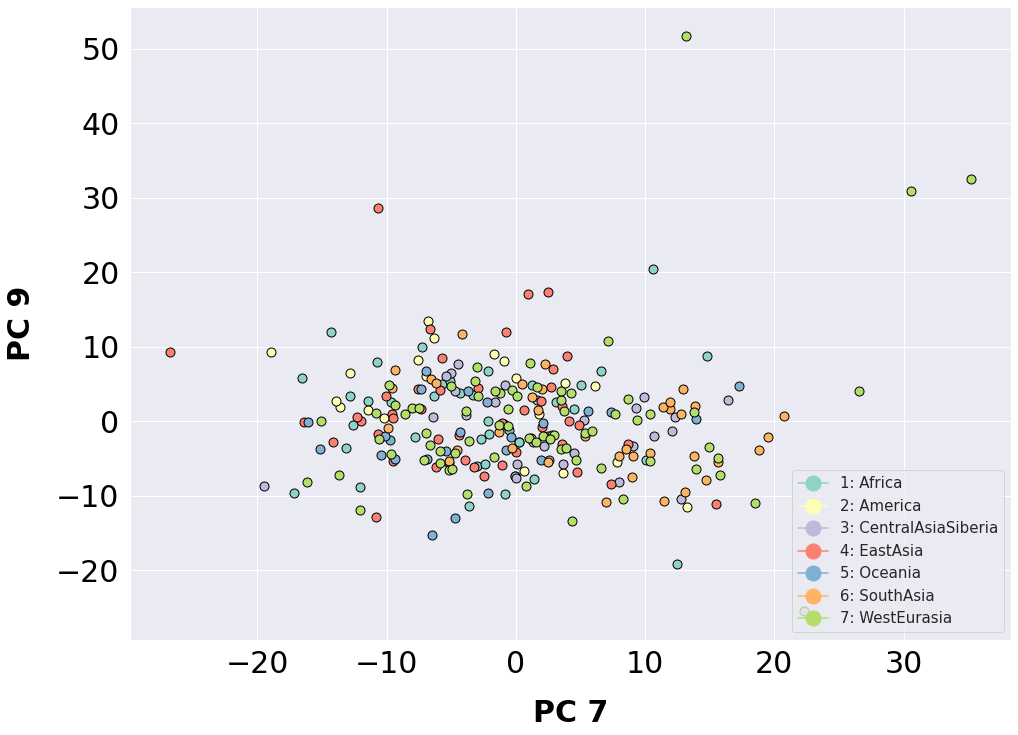

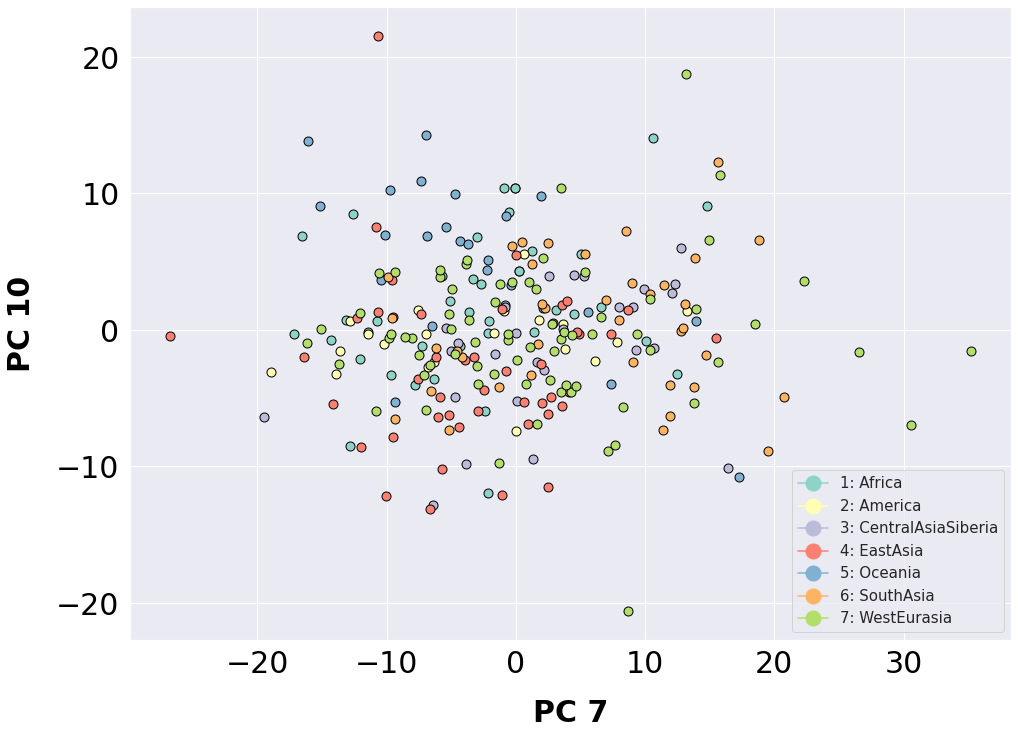

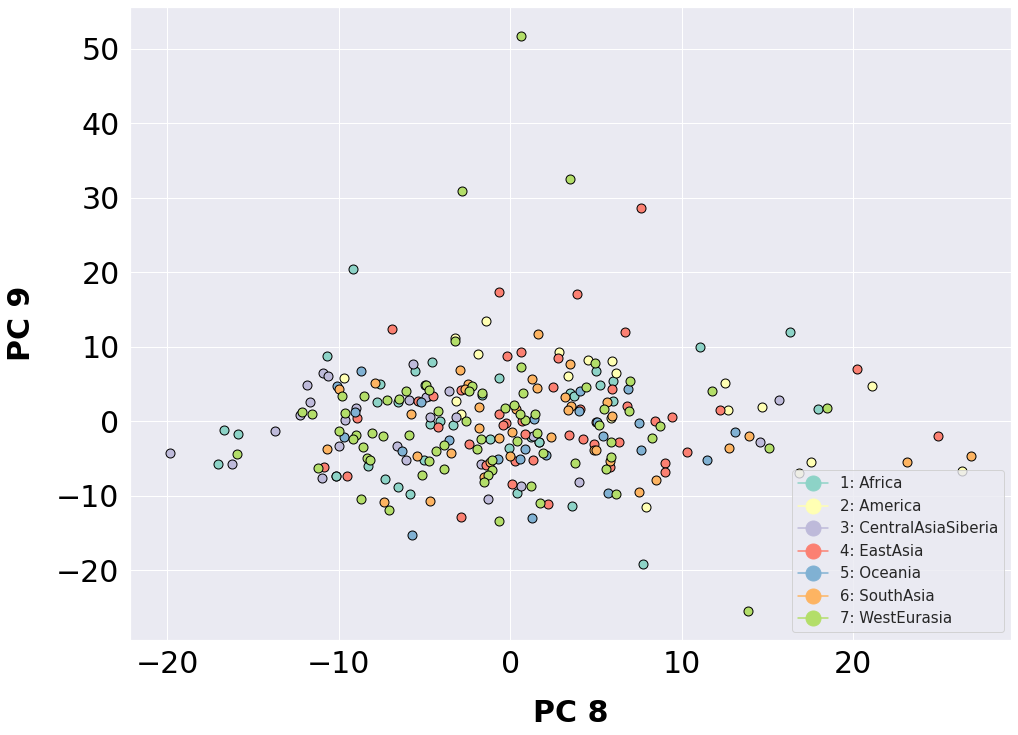

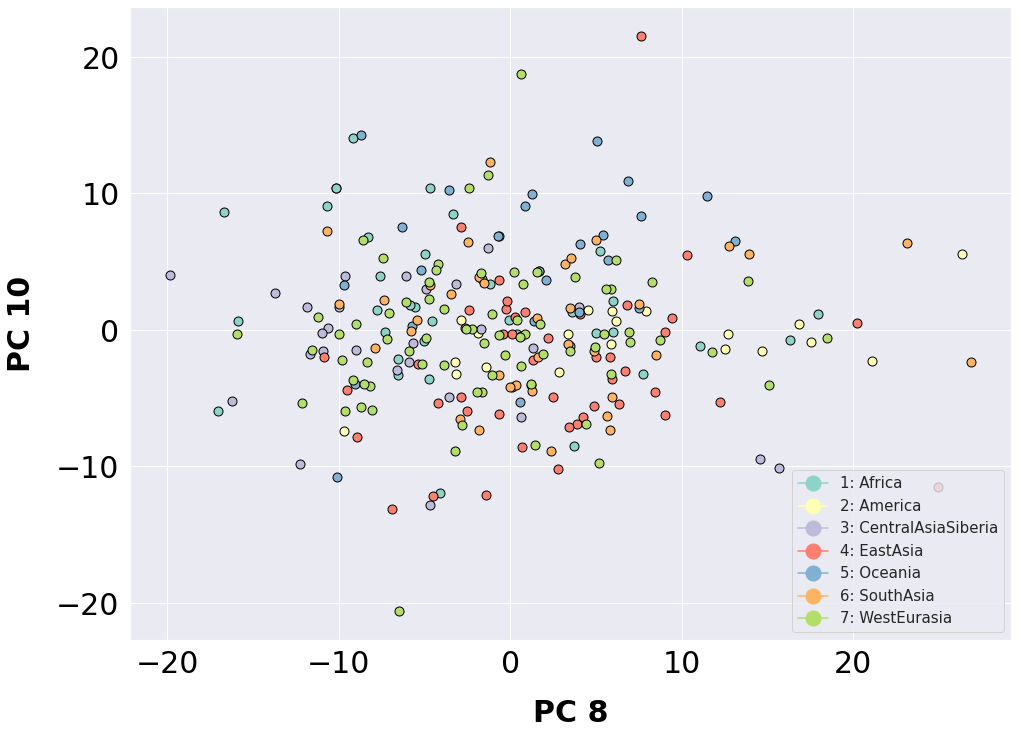

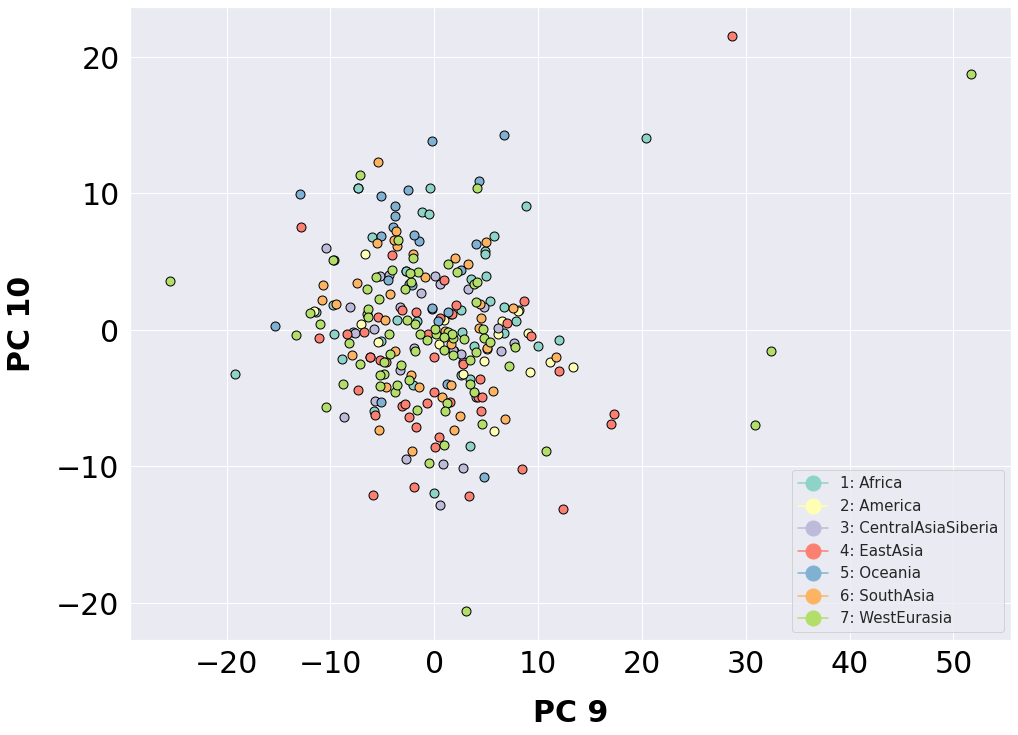

In [40]:
components = [1,2,3,4,5,6,7,8,9,10]

combinations_components = list(combinations(components,2))
for i in combinations_components:
    plot_scatter_cluster(data=df_pca, abscissa='component_'+str(i[0]), ordinate='component_'+str(i[1]), label_horizontal='PC '+ str(i[0]), label_vertical='PC '+str(i[1]), factor='REGION', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    #print(str(i[0]))
#    plot_scatter_cluster(data=df_pca, abscissa='component_8', ordinate='component_9', label_horizontal='Component 1', label_vertical='Component 3', factor='10-Region', fonts=define_font_properties(), colors=define_color_properties(), legend=True)
    

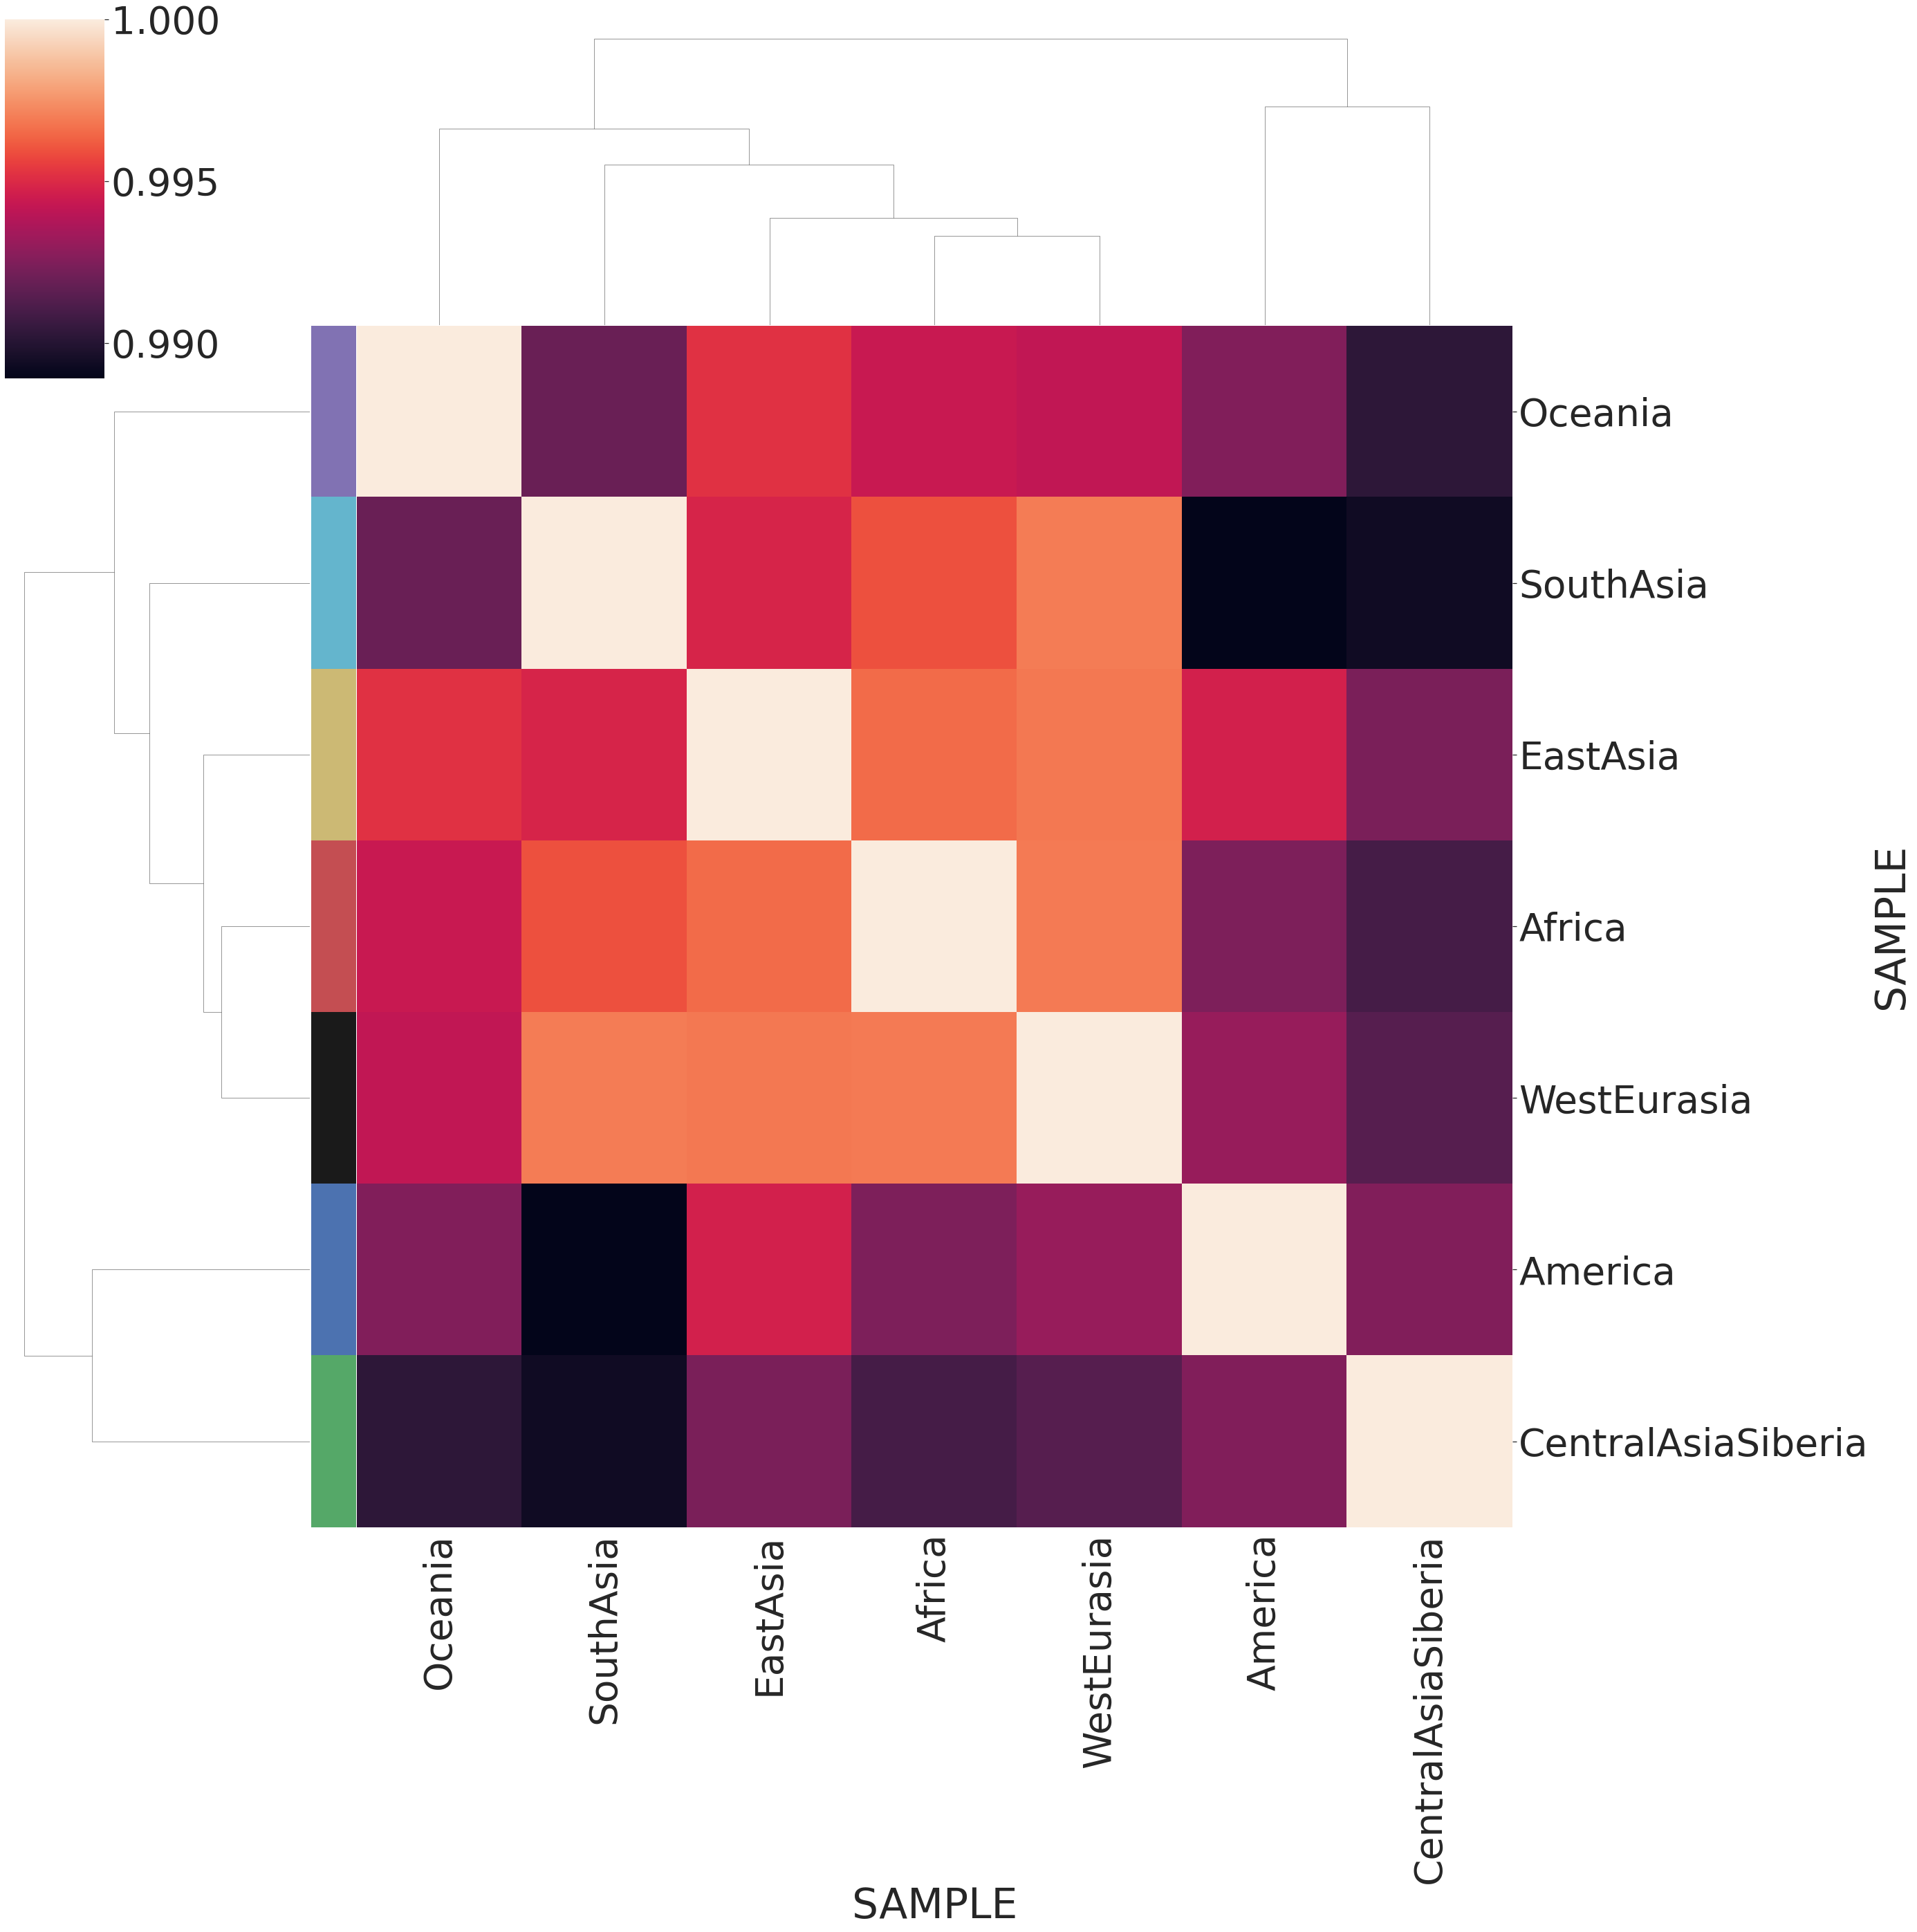

In [41]:
freq = final_cnv.iloc[:,3:283]
freq_input = freq.rename(columns=features['REGION'])
df = freq_input.T
#df = df.reset_index()

#df.groupby('SAMPLE').count().div(df.groupby('SAMPLE').size(),0)


df = df.notnull().groupby(level=0).mean()

df = df.T

lut = dict(zip(df.columns.unique(), "rbgymck"))
lut

seaborn.set(font_scale=5)
corrmatrix = df.corr(method='pearson')
row_colors = df.columns.map(lut)
seaborn.clustermap(corrmatrix, row_colors=row_colors, row_cluster=True, figsize=(40,40))
#plt.savefig('clustermap_regions.pdf')

In [79]:
feature_table = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('/branchinecta/jbazanwilliamson/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [82]:
chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
chm13_gene_anotation


# feature                   class         assembly     assembly_unit  \
0           gene          protein_coding  GCF_009914755.1  Primary Assembly   
1           mRNA                     NaN  GCF_009914755.1  Primary Assembly   
2            CDS            with_protein  GCF_009914755.1  Primary Assembly   
3           gene                  lncRNA  GCF_009914755.1  Primary Assembly   
4          ncRNA                  lncRNA  GCF_009914755.1  Primary Assembly   
...          ...                     ...              ...               ...   
236307      gene          protein_coding  GCF_009914755.1  Primary Assembly   
236308      mRNA                     NaN  GCF_009914755.1  Primary Assembly   
236309       CDS            with_protein  GCF_009914755.1  Primary Assembly   
236310      gene  transcribed_pseudogene  GCF_009914755.1  Primary Assembly   
236311  misc_RNA                     NaN  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
1       chromosome          1       NC_060925.1     11134     37628      -   
2       chromosome          1       NC_060925.1     13463     37628      -   
3       chromosome          1       NC_060925.1     20892     23710      -   
4       chromosome          1       NC_060925.1     20892     23710      -   
...            ...        ...               ...       ...       ...    ...   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   
236308  chromosome          Y       NC_060948.1  62446549  62449392      +   
236309  chromosome          Y       NC_060948.1  62446549  62449100      +   
236310  chromosome          Y       NC_060948.1  62449384  62451910      -   
236311  chromosome          Y       NC_060948.1  62449384  62451910      -   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
1       ...             1  assembled-molecule                 1   
2       ...             1  assembled-molecule                 1   
3       ...             1  assembled-molecule                 1   
4       ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
236307  ...             Y  assembled-molecule                 Y   
236308  ...             Y  assembled-molecule                 Y   
236309  ...             Y  assembled-molecule                 Y   
236310  ...             Y  assembled-molecule                 Y   
236311  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
1                           Chromosome   CP068277.2             =   
2                           Chromosome   CP068277.2             =   
3                           Chromosome   CP068277.2             =   
4                           Chromosome   CP068277.2             =   
...                                ...          ...           ...   
236307                      Chromosome   CP086569.2             =   
236308                      Chromosome   CP086569.2             =   
236309                      Chromosome   CP086569.2             =   
236310                      Chromosome   CP086569.2             =   
236311                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
1       NC_060925.1  Primary Assembly        248387328              na  
2       NC_060925.1  Primary Assembly        248387328              na  
3       NC_060925.1  Primary Assembly        248387328              na  
4       NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...            

# feature           class         assembly     assembly_unit  \
0           gene  protein_coding  GCF_009914755.1  Primary Assembly   
7           gene  protein_coding  GCF_009914755.1  Primary Assembly   
42          gene  protein_coding  GCF_009914755.1  Primary Assembly   
49          gene  protein_coding  GCF_009914755.1  Primary Assembly   
52          gene  protein_coding  GCF_009914755.1  Primary Assembly   
...          ...             ...              ...               ...   
232256      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236280      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236288      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236300      gene  protein_coding  GCF_009914755.1  Primary Assembly   
236307      gene  protein_coding  GCF_009914755.1  Primary Assembly   

          seq_type chromosome genomic_accession     start       end strand  \
0       chromosome          1       NC_060925.1     11134     37628      -   
7       chromosome          1       NC_060925.1    111940    112877      -   
42      chromosome          1       NC_060925.1    353566    373316      +   
49      chromosome          1       NC_060925.1    372945    388041      -   
52      chromosome          1       NC_060925.1    389374    394430      +   
...            ...        ...               ...       ...       ...    ...   
232256  chromosome          Y       NC_060948.1  36480752  36497801      +   
236280  chromosome          Y       NC_060948.1  62190003  62204700      +   
236288  chromosome          Y       NC_060948.1  62306325  62368760      +   
236300  chromosome          Y       NC_060948.1  62422687  62435805      +   
236307  chromosome          Y       NC_060948.1  62446549  62449392      +   

        ... Sequence-Name       Sequence-Role Assigned-Molecule  \
0       ...             1  assembled-molecule                 1   
7       ...             1  assembled-molecule                 1   
42      ...             1  assembled-molecule                 1   
49      ...             1  assembled-molecule                 1   
52      ...             1  assembled-molecule                 1   
...     ...           ...                 ...               ...   
232256  ...             Y  assembled-molecule                 Y   
236280  ...             Y  assembled-molecule                 Y   
236288  ...             Y  assembled-molecule                 Y   
236300  ...             Y  assembled-molecule                 Y   
236307  ...             Y  assembled-molecule                 Y   

       Assigned-Molecule-Location/Type GenBank-Accn  Relationship  \
0                           Chromosome   CP068277.2             =   
7                           Chromosome   CP068277.2             =   
42                          Chromosome   CP068277.2             =   
49                          Chromosome   CP068277.2             =   
52                          Chromosome   CP068277.2             =   
...                                ...          ...           ...   
232256                      Chromosome   CP086569.2             =   
236280                      Chromosome   CP086569.2             =   
236288                      Chromosome   CP086569.2             =   
236300                      Chromosome   CP086569.2             =   
236307                      Chromosome   CP086569.2             =   

        RefSeq-Accn     Assembly-Unit  Sequence-Length UCSC-style-name  
0       NC_060925.1  Primary Assembly        248387328              na  
7       NC_060925.1  Primary Assembly        248387328              na  
42      NC_060925.1  Primary Assembly        248387328              na  
49      NC_060925.1  Primary Assembly        248387328              na  
52      NC_060925.1  Primary Assembly        248387328              na  
...             ...               ...              ...             ...  
232256  NC_060948.1  Primary Assembly         62460029              na  

In [59]:
new

# feature                   class         assembly  \
chromosome                                                      
1               gene          protein_coding  GCF_009914755.1   
1               mRNA                     NaN  GCF_009914755.1   
1                CDS            with_protein  GCF_009914755.1   
1               gene                  lncRNA  GCF_009914755.1   
1              ncRNA                  lncRNA  GCF_009914755.1   
...              ...                     ...              ...   
Y               gene          protein_coding  GCF_009914755.1   
Y               mRNA                     NaN  GCF_009914755.1   
Y                CDS            with_protein  GCF_009914755.1   
Y               gene  transcribed_pseudogene  GCF_009914755.1   
Y           misc_RNA                     NaN  GCF_009914755.1   

               assembly_unit    seq_type genomic_accession     start  \
chromosome                                                             
1           Primary Assembly  chromosome       NC_060925.1     11134   
1           Primary Assembly  chromosome       NC_060925.1     11134   
1           Primary Assembly  chromosome       NC_060925.1     13463   
1           Primary Assembly  chromosome       NC_060925.1     20892   
1           Primary Assembly  chromosome       NC_060925.1     20892   
...                      ...         ...               ...       ...   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62446549   
Y           Primary Assembly  chromosome       NC_060948.1  62449384   
Y           Primary Assembly  chromosome       NC_060948.1  62449384   

                 end strand product_accession  non-redundant_refseq  \
chromosome                                                            
1              37628      -               NaN                   NaN   
1              37628      -    XM_047443605.1                   NaN   
1              37628      -    XP_047299561.1                   NaN   
1              23710      -               NaN                   NaN   
1              23710      -    XR_007069731.1                   NaN   
...              ...    ...               ...                   ...   
Y           62449392      +               NaN                   NaN   
Y           62449392      +    XM_047447183.1                   NaN   
Y           62449100      +    XP_047303139.1                   NaN   
Y           62451910      -               NaN                   NaN   
Y           62451910      -       NR_110561.1                   NaN   

           related_accession  \
chromosome                     
1                        NaN   
1             XP_047299561.1   
1             XM_047443605.1   
1                        NaN   
1                        NaN   
...                      ...   
Y                        NaN   
Y             XP_047303139.1   
Y             XM_047447183.1   
Y                        NaN   
Y                        NaN   

                                                         name        symbol  \
chromosome                                                                    
1                                                         NaN  LOC105378947   
1           proline-rich extensin-like protein EPR1, trans...  LOC105378947   
1             uncharacterized protein LOC105378947 isoform X2  LOC105378947   
1                                                         NaN  LOC124905685   
1                                uncharacterized LOC124905685  LOC124905685   
...                                                       ...           ...   
Y                                                         NaN  LOC124908905   
Y                           WAS protein family homolog 6-like  LOC124908905   
Y                           WAS protein family homolog 6-like  LOC124908905   
Y                 